In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, SimpleRNN, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.8)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    rnn_1 = SimpleRNN(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = BatchNormalization()(rnn_1)
    rnn_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    rnn_1_droput = Dropout(0.3)(rnn_1_LRelu)
    rnn_2 = SimpleRNN(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(rnn_1_droput)
    batch_norm2 = BatchNormalization()(rnn_2)
    rnn_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    rnn_2_droput = Dropout(0.3)(rnn_2_LRelu)
    output_dense = Dense(n_features, activation=None)(rnn_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "AMZN"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    3.628125    3.631250    3.278125    3.459375    3.459375   
6    2000-01-11    3.343750    3.500000    3.250000    3.337500    3.337500   
7    2000-01-12    3.393750    3.400000    3.150000    3.178125    3.178125   
8    2000-01-13    3.246875    3.359375    3.156250    3.296875    3.296875   
9    2000-01-14    3.337500    3.431250    3.200000    3.212500    3.212500   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  160.250000  160.506500  159.208496  159.263504  159.263504   
5279 2020-12-24  159.695007  160.100006  158.449997  158.634506  158.634506   
5280 2020-12-28  159.699997  165.199997  158.634506  164.197998  164.197998   
5281 2020-12-29  165.496994  167.532501  164.061005  166.100006  166.100006   
5282 2020-12-30  167.050003  167.104996  164.123505  164.292496  164.292496   

         Volume          Ma  
5     295158000    3.761875  
6     210654000    3.560000  
7     216090000    3.408125  
8     208962000    3.346250  
9     137072000    3.350000  
...         ...         ...  
5278   41876000  160.913904  
5279   29038000  160.357004  
5280  113736000  159.723105  
5281   97458000  160.546204  
5282   64186000  161.704404  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 10)             180       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                             

Time for epoch 53 is 0.6921520233154297 sec Generator Loss: 1.1333805322647095,  Discriminator_loss: 1.1473150253295898
Time for epoch 54 is 0.6808481216430664 sec Generator Loss: 1.106024146080017,  Discriminator_loss: 1.1505987644195557
Time for epoch 55 is 0.7106478214263916 sec Generator Loss: 1.1016783714294434,  Discriminator_loss: 1.1701580286026
Time for epoch 56 is 0.7182719707489014 sec Generator Loss: 1.1131664514541626,  Discriminator_loss: 1.1603425741195679
Time for epoch 57 is 0.7637660503387451 sec Generator Loss: 1.0626699924468994,  Discriminator_loss: 1.1770427227020264
Time for epoch 58 is 0.7653329372406006 sec Generator Loss: 1.081969141960144,  Discriminator_loss: 1.1668164730072021
Time for epoch 59 is 0.7110567092895508 sec Generator Loss: 1.0946882963180542,  Discriminator_loss: 1.1709613800048828
Time for epoch 60 is 0.7272241115570068 sec Generator Loss: 1.0815057754516602,  Discriminator_loss: 1.179069995880127
Time for epoch 61 is 0.7116837501525879 sec Ge

Time for epoch 122 is 0.7244527339935303 sec Generator Loss: 0.9942138195037842,  Discriminator_loss: 1.2440919876098633
Time for epoch 123 is 0.6856036186218262 sec Generator Loss: 0.9837461113929749,  Discriminator_loss: 1.2430638074874878
Time for epoch 124 is 0.6779935359954834 sec Generator Loss: 0.9857633709907532,  Discriminator_loss: 1.2460607290267944
Time for epoch 125 is 0.6725280284881592 sec Generator Loss: 0.9848916530609131,  Discriminator_loss: 1.2532870769500732
Time for epoch 126 is 0.6912498474121094 sec Generator Loss: 0.9745592474937439,  Discriminator_loss: 1.2514463663101196
Time for epoch 127 is 0.7369318008422852 sec Generator Loss: 0.9846519827842712,  Discriminator_loss: 1.2532931566238403
Time for epoch 128 is 0.6940231323242188 sec Generator Loss: 0.9911812543869019,  Discriminator_loss: 1.2519856691360474
Time for epoch 129 is 0.6800472736358643 sec Generator Loss: 0.970910370349884,  Discriminator_loss: 1.2552260160446167
Time for epoch 130 is 0.684834241

Time for epoch 190 is 0.7786715030670166 sec Generator Loss: 0.9648386836051941,  Discriminator_loss: 1.2584381103515625
Time for epoch 191 is 0.7404251098632812 sec Generator Loss: 0.9439170956611633,  Discriminator_loss: 1.2609599828720093
Time for epoch 192 is 0.7021541595458984 sec Generator Loss: 0.969868004322052,  Discriminator_loss: 1.2481403350830078
Time for epoch 193 is 0.7121179103851318 sec Generator Loss: 0.9636188745498657,  Discriminator_loss: 1.2568955421447754
Time for epoch 194 is 0.7112510204315186 sec Generator Loss: 0.9335798621177673,  Discriminator_loss: 1.2671294212341309
Time for epoch 195 is 0.7026560306549072 sec Generator Loss: 0.9948194026947021,  Discriminator_loss: 1.2588951587677002
Time for epoch 196 is 0.7848782539367676 sec Generator Loss: 0.9434882402420044,  Discriminator_loss: 1.2659814357757568
Time for epoch 197 is 0.7402331829071045 sec Generator Loss: 0.9671624898910522,  Discriminator_loss: 1.256725788116455
Time for epoch 198 is 0.6953208446

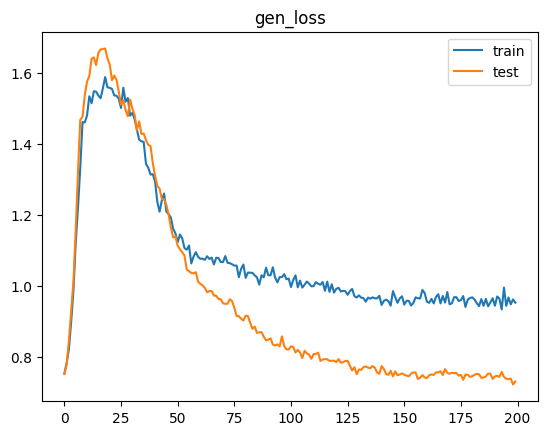

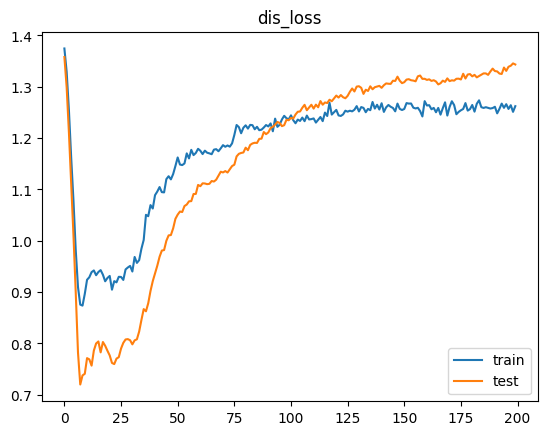

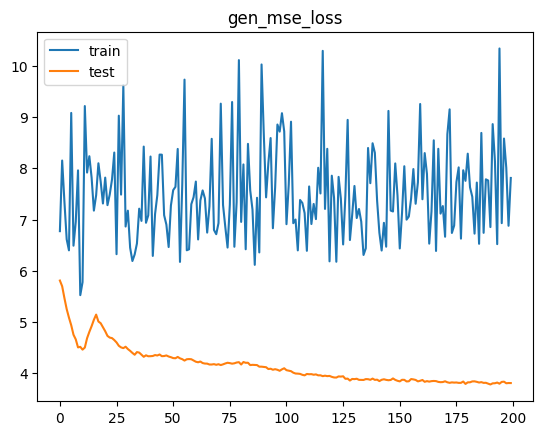

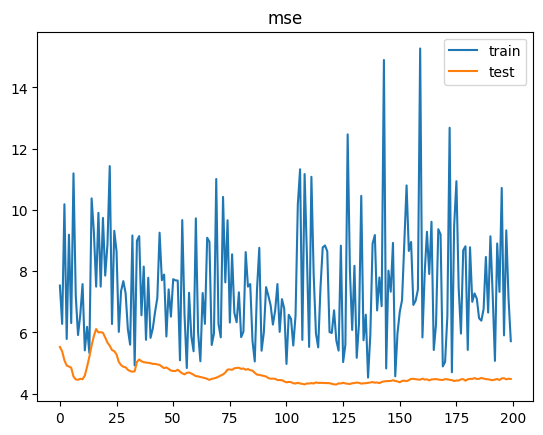

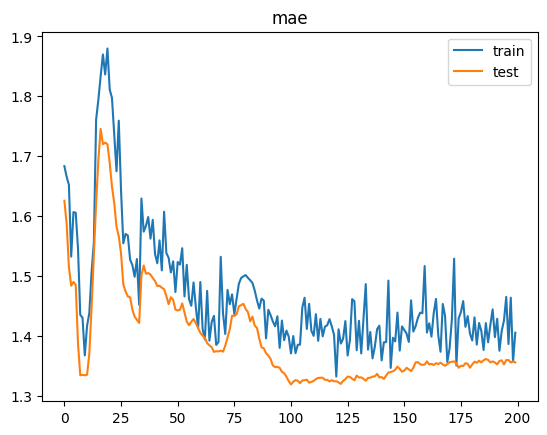

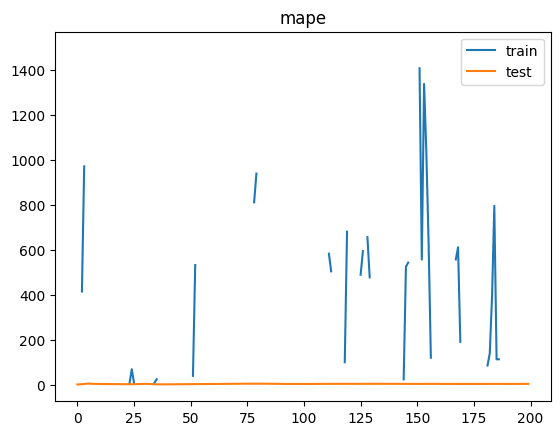

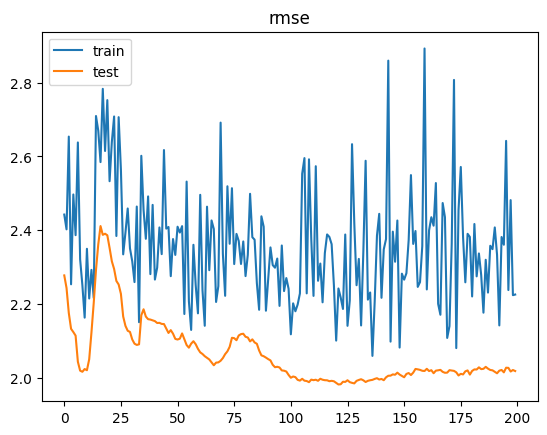

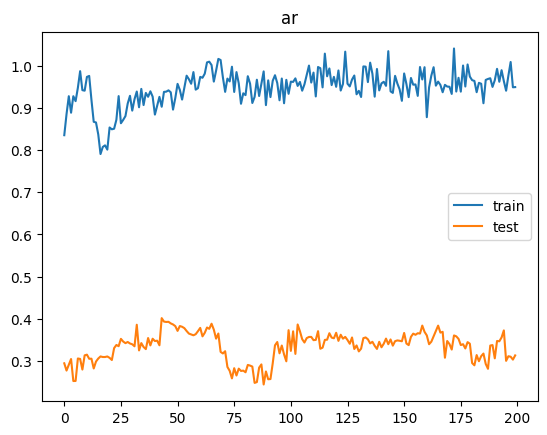

2/2 [==============================] - 0s 2ms/step


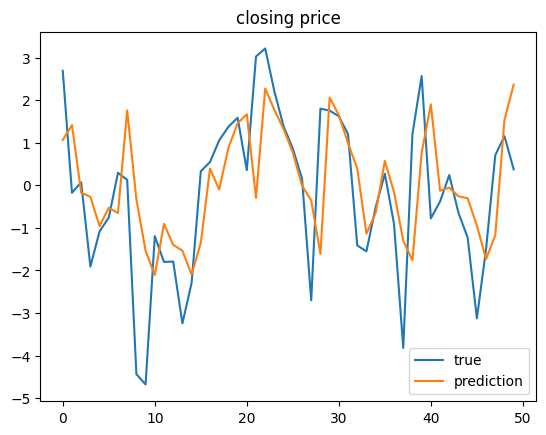

[MSE Baseline] train: 6.655938178214935  test: 4.137918162168212
Delta time with epochs = 200: 0:02:32.346490
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 simple_rnn_3 (

Time for epoch 53 is 0.7407114505767822 sec Generator Loss: 0.980852484703064,  Discriminator_loss: 1.2506988048553467
Time for epoch 54 is 0.7304940223693848 sec Generator Loss: 0.9837675094604492,  Discriminator_loss: 1.2471102476119995
Time for epoch 55 is 0.9775218963623047 sec Generator Loss: 0.9733119010925293,  Discriminator_loss: 1.2538917064666748
Time for epoch 56 is 0.6924636363983154 sec Generator Loss: 0.9917901158332825,  Discriminator_loss: 1.2358185052871704
Time for epoch 57 is 0.6898374557495117 sec Generator Loss: 0.9785988926887512,  Discriminator_loss: 1.2376205921173096
Time for epoch 58 is 0.6858041286468506 sec Generator Loss: 0.9913290143013,  Discriminator_loss: 1.2397682666778564
Time for epoch 59 is 0.6987056732177734 sec Generator Loss: 0.9975422024726868,  Discriminator_loss: 1.2379059791564941
Time for epoch 60 is 0.73537278175354 sec Generator Loss: 0.9972496032714844,  Discriminator_loss: 1.2304173707962036
Time for epoch 61 is 0.7065560817718506 sec Ge

Time for epoch 122 is 0.7961978912353516 sec Generator Loss: 0.9158187508583069,  Discriminator_loss: 1.2863879203796387
Time for epoch 123 is 0.744509220123291 sec Generator Loss: 0.9194379448890686,  Discriminator_loss: 1.2744649648666382
Time for epoch 124 is 0.7331602573394775 sec Generator Loss: 0.9238476157188416,  Discriminator_loss: 1.2745391130447388
Time for epoch 125 is 0.7261312007904053 sec Generator Loss: 0.9396819472312927,  Discriminator_loss: 1.2747050523757935
Time for epoch 126 is 0.7123465538024902 sec Generator Loss: 0.9321177005767822,  Discriminator_loss: 1.2721196413040161
Time for epoch 127 is 0.7297525405883789 sec Generator Loss: 0.9304163455963135,  Discriminator_loss: 1.2813609838485718
Time for epoch 128 is 0.7108664512634277 sec Generator Loss: 0.9017944931983948,  Discriminator_loss: 1.285742163658142
Time for epoch 129 is 0.739840030670166 sec Generator Loss: 0.9380833506584167,  Discriminator_loss: 1.2829861640930176
Time for epoch 130 is 0.69932794570

Time for epoch 190 is 0.736799955368042 sec Generator Loss: 0.8912369012832642,  Discriminator_loss: 1.2946118116378784
Time for epoch 191 is 0.7289915084838867 sec Generator Loss: 0.9017173647880554,  Discriminator_loss: 1.2956516742706299
Time for epoch 192 is 0.7750916481018066 sec Generator Loss: 0.8801864981651306,  Discriminator_loss: 1.3063586950302124
Time for epoch 193 is 0.7645001411437988 sec Generator Loss: 0.8868974447250366,  Discriminator_loss: 1.3016135692596436
Time for epoch 194 is 0.727508544921875 sec Generator Loss: 0.9113036394119263,  Discriminator_loss: 1.3029603958129883
Time for epoch 195 is 0.7634413242340088 sec Generator Loss: 0.8958808779716492,  Discriminator_loss: 1.3009510040283203
Time for epoch 196 is 0.734553337097168 sec Generator Loss: 0.8820627927780151,  Discriminator_loss: 1.3043822050094604
Time for epoch 197 is 0.7720844745635986 sec Generator Loss: 0.8868959546089172,  Discriminator_loss: 1.3041719198226929
Time for epoch 198 is 0.71336126327

Time for epoch 258 is 0.6828837394714355 sec Generator Loss: 0.9006822109222412,  Discriminator_loss: 1.2941391468048096
Time for epoch 259 is 0.6732151508331299 sec Generator Loss: 0.9088095426559448,  Discriminator_loss: 1.3013211488723755
Time for epoch 260 is 0.7100396156311035 sec Generator Loss: 0.8933451771736145,  Discriminator_loss: 1.301889419555664
Time for epoch 261 is 0.7062363624572754 sec Generator Loss: 0.8968182802200317,  Discriminator_loss: 1.2787669897079468
Time for epoch 262 is 0.784679651260376 sec Generator Loss: 0.8910919427871704,  Discriminator_loss: 1.2958370447158813
Time for epoch 263 is 0.7314527034759521 sec Generator Loss: 0.8949074745178223,  Discriminator_loss: 1.2917636632919312
Time for epoch 264 is 0.7180993556976318 sec Generator Loss: 0.8971990942955017,  Discriminator_loss: 1.3001391887664795
Time for epoch 265 is 0.7214083671569824 sec Generator Loss: 0.9060664772987366,  Discriminator_loss: 1.2923047542572021
Time for epoch 266 is 0.7224457263

Time for epoch 327 is 0.6814610958099365 sec Generator Loss: 0.8983559012413025,  Discriminator_loss: 1.2852849960327148
Time for epoch 328 is 0.7025351524353027 sec Generator Loss: 0.9008517861366272,  Discriminator_loss: 1.2907371520996094
Time for epoch 329 is 0.6729061603546143 sec Generator Loss: 0.8939817547798157,  Discriminator_loss: 1.2944285869598389
Time for epoch 330 is 0.6841440200805664 sec Generator Loss: 0.9050936102867126,  Discriminator_loss: 1.2877660989761353
Time for epoch 331 is 0.7236242294311523 sec Generator Loss: 0.8958567380905151,  Discriminator_loss: 1.2903130054473877
Time for epoch 332 is 0.7225031852722168 sec Generator Loss: 0.8993588089942932,  Discriminator_loss: 1.2901232242584229
Time for epoch 333 is 0.6811473369598389 sec Generator Loss: 0.9052854180335999,  Discriminator_loss: 1.2902387380599976
Time for epoch 334 is 0.6799685955047607 sec Generator Loss: 0.9256494045257568,  Discriminator_loss: 1.2830946445465088
Time for epoch 335 is 0.69777607

Time for epoch 395 is 0.6821873188018799 sec Generator Loss: 0.8855838179588318,  Discriminator_loss: 1.3069862127304077
Time for epoch 396 is 0.6804394721984863 sec Generator Loss: 0.8995819091796875,  Discriminator_loss: 1.2908738851547241
Time for epoch 397 is 0.6754109859466553 sec Generator Loss: 0.8951446413993835,  Discriminator_loss: 1.2952446937561035
Time for epoch 398 is 0.6754329204559326 sec Generator Loss: 0.9016271829605103,  Discriminator_loss: 1.3004834651947021
Time for epoch 399 is 0.6842098236083984 sec Generator Loss: 0.8768118023872375,  Discriminator_loss: 1.3016290664672852
Time for epoch 400 is 0.7226612567901611 sec Generator Loss: 0.9289799928665161,  Discriminator_loss: 1.2981884479522705
Time for epoch 401 is 0.7207057476043701 sec Generator Loss: 0.9083329439163208,  Discriminator_loss: 1.296067476272583
Time for epoch 402 is 0.6698238849639893 sec Generator Loss: 0.8929518461227417,  Discriminator_loss: 1.307906985282898
Time for epoch 403 is 0.6843676567

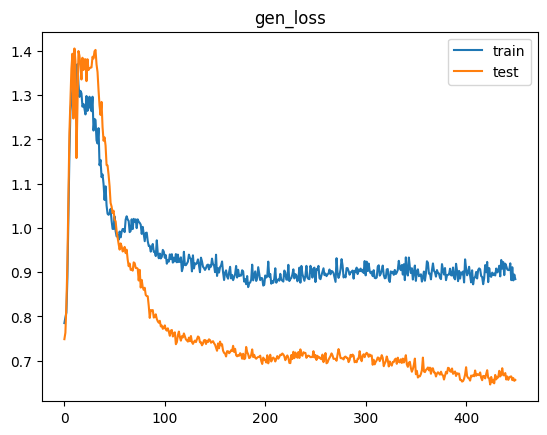

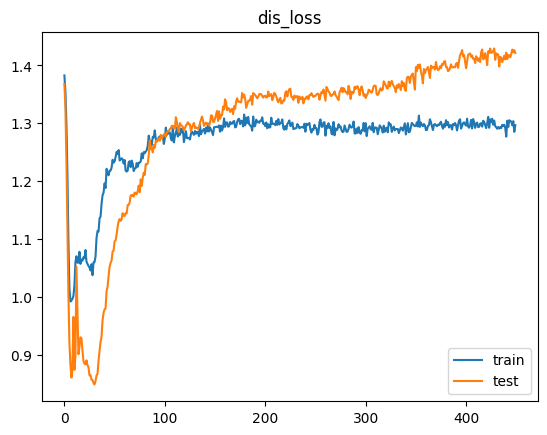

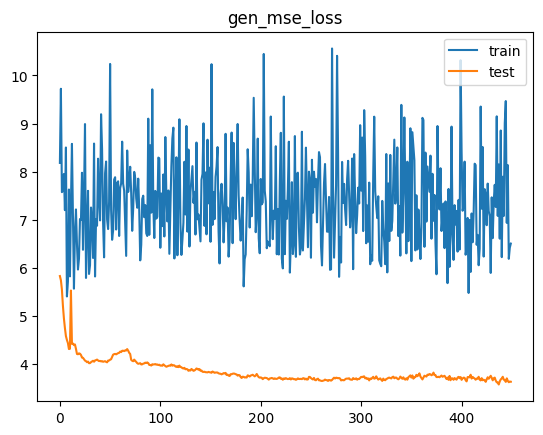

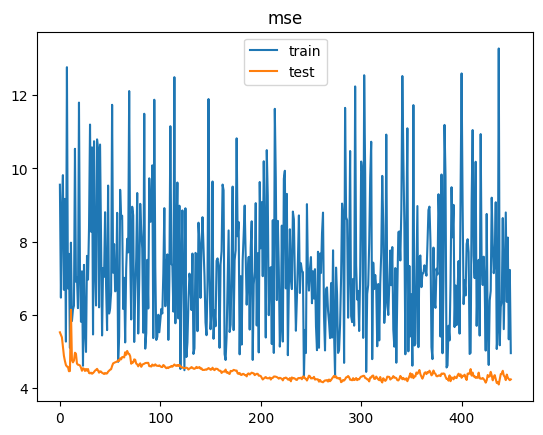

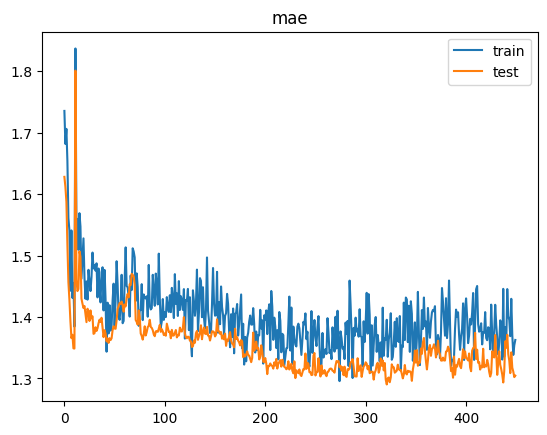

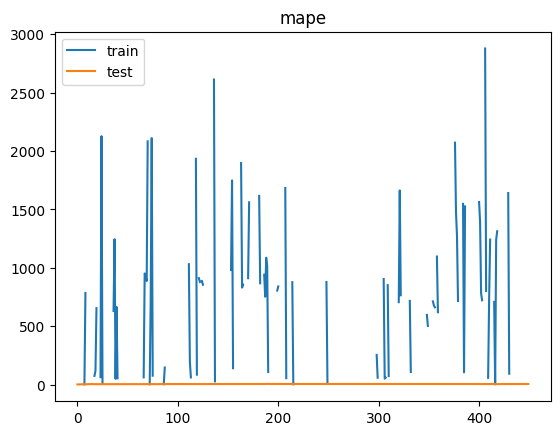

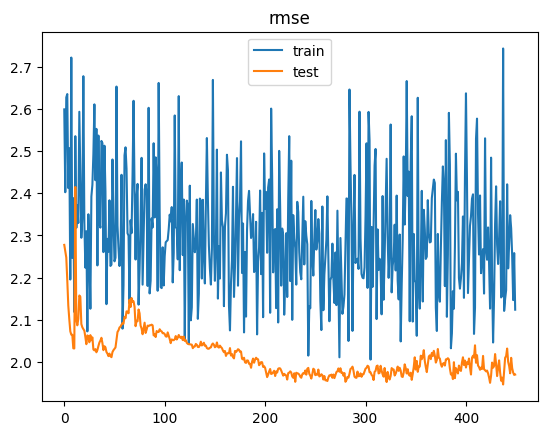

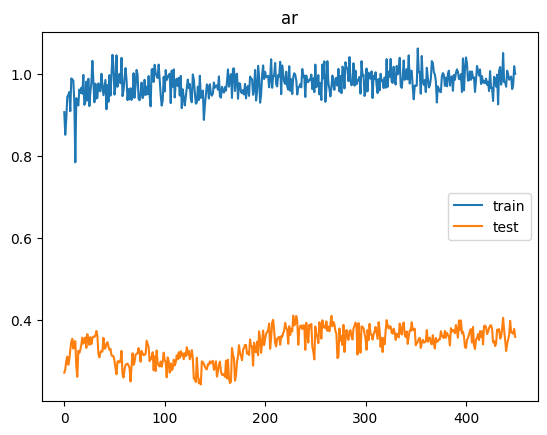

2/2 [==============================] - 0s 2ms/step


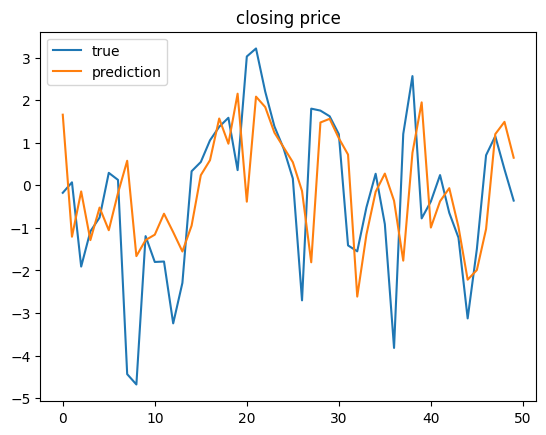

[MSE Baseline] train: 7.604425509868903  test: 4.1521541466081695
Delta time with epochs = 450: 0:05:32.920312
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_5 

In [ ]:
for epochs in [200, 450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 10)             180       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                             

Time for epoch 53 is 0.6049337387084961 sec Generator Loss: 1.0282504558563232,  Discriminator_loss: 1.1896287202835083
Time for epoch 54 is 0.6180267333984375 sec Generator Loss: 1.0313533544540405,  Discriminator_loss: 1.2152984142303467
Time for epoch 55 is 0.6160194873809814 sec Generator Loss: 0.9989615678787231,  Discriminator_loss: 1.218926191329956
Time for epoch 56 is 0.6163132190704346 sec Generator Loss: 0.9983008503913879,  Discriminator_loss: 1.212036371231079
Time for epoch 57 is 0.6060407161712646 sec Generator Loss: 1.0090354681015015,  Discriminator_loss: 1.215682864189148
Time for epoch 58 is 0.612807035446167 sec Generator Loss: 1.0188449621200562,  Discriminator_loss: 1.2043904066085815
Time for epoch 59 is 0.6171844005584717 sec Generator Loss: 1.0200610160827637,  Discriminator_loss: 1.2058894634246826
Time for epoch 60 is 0.6039204597473145 sec Generator Loss: 1.0114997625350952,  Discriminator_loss: 1.2011311054229736
Time for epoch 61 is 0.6602492332458496 sec 

Time for epoch 122 is 0.6737959384918213 sec Generator Loss: 0.9526516795158386,  Discriminator_loss: 1.2421597242355347
Time for epoch 123 is 0.6535854339599609 sec Generator Loss: 0.9490737318992615,  Discriminator_loss: 1.2543450593948364
Time for epoch 124 is 0.6613318920135498 sec Generator Loss: 0.9565442204475403,  Discriminator_loss: 1.2513002157211304
Time for epoch 125 is 0.7059323787689209 sec Generator Loss: 0.9689679145812988,  Discriminator_loss: 1.2538847923278809
Time for epoch 126 is 0.6695773601531982 sec Generator Loss: 0.9424231648445129,  Discriminator_loss: 1.2579033374786377
Time for epoch 127 is 0.6961264610290527 sec Generator Loss: 0.9438258409500122,  Discriminator_loss: 1.2472001314163208
Time for epoch 128 is 0.682060718536377 sec Generator Loss: 0.9321662187576294,  Discriminator_loss: 1.2592872381210327
Time for epoch 129 is 0.6617724895477295 sec Generator Loss: 0.9444471597671509,  Discriminator_loss: 1.2510297298431396
Time for epoch 130 is 0.663760662

Time for epoch 191 is 0.6464908123016357 sec Generator Loss: 0.9470885992050171,  Discriminator_loss: 1.259154200553894
Time for epoch 192 is 0.6478464603424072 sec Generator Loss: 0.9353377819061279,  Discriminator_loss: 1.2439525127410889
Time for epoch 193 is 0.6522312164306641 sec Generator Loss: 0.9460995197296143,  Discriminator_loss: 1.258105993270874
Time for epoch 194 is 0.6501109600067139 sec Generator Loss: 0.9497475624084473,  Discriminator_loss: 1.2499231100082397
Time for epoch 195 is 0.6446857452392578 sec Generator Loss: 0.9517580270767212,  Discriminator_loss: 1.2623810768127441
Time for epoch 196 is 0.6439082622528076 sec Generator Loss: 0.9323914051055908,  Discriminator_loss: 1.2570122480392456
Time for epoch 197 is 0.6402974128723145 sec Generator Loss: 0.9536277651786804,  Discriminator_loss: 1.255002737045288
Time for epoch 198 is 0.6468591690063477 sec Generator Loss: 0.9370293021202087,  Discriminator_loss: 1.2597005367279053
Time for epoch 199 is 0.64238739013

Time for epoch 259 is 0.6320068836212158 sec Generator Loss: 0.9241852164268494,  Discriminator_loss: 1.2680705785751343
Time for epoch 260 is 0.6486132144927979 sec Generator Loss: 0.9270225763320923,  Discriminator_loss: 1.2669273614883423
Time for epoch 261 is 0.6397147178649902 sec Generator Loss: 0.9082146883010864,  Discriminator_loss: 1.2659744024276733
Time for epoch 262 is 0.6498732566833496 sec Generator Loss: 0.9581754207611084,  Discriminator_loss: 1.2602542638778687
Time for epoch 263 is 0.6448245048522949 sec Generator Loss: 0.9277868270874023,  Discriminator_loss: 1.2644274234771729
Time for epoch 264 is 0.6406943798065186 sec Generator Loss: 0.935206413269043,  Discriminator_loss: 1.263287901878357
Time for epoch 265 is 0.6338841915130615 sec Generator Loss: 0.9428120851516724,  Discriminator_loss: 1.2633200883865356
Time for epoch 266 is 0.6395113468170166 sec Generator Loss: 0.925337016582489,  Discriminator_loss: 1.2681509256362915
Time for epoch 267 is 0.63796448707

Time for epoch 327 is 0.6348562240600586 sec Generator Loss: 0.909099817276001,  Discriminator_loss: 1.2723972797393799
Time for epoch 328 is 0.6607961654663086 sec Generator Loss: 0.9144614338874817,  Discriminator_loss: 1.2794609069824219
Time for epoch 329 is 0.6816353797912598 sec Generator Loss: 0.9108107089996338,  Discriminator_loss: 1.2693908214569092
Time for epoch 330 is 0.75494384765625 sec Generator Loss: 0.9117178320884705,  Discriminator_loss: 1.2736481428146362
Time for epoch 331 is 0.7548837661743164 sec Generator Loss: 0.9270665049552917,  Discriminator_loss: 1.2733228206634521
Time for epoch 332 is 0.679330587387085 sec Generator Loss: 0.9024783372879028,  Discriminator_loss: 1.2722235918045044
Time for epoch 333 is 0.6622908115386963 sec Generator Loss: 0.9136636257171631,  Discriminator_loss: 1.274935245513916
Time for epoch 334 is 0.6339893341064453 sec Generator Loss: 0.9390104413032532,  Discriminator_loss: 1.2677130699157715
Time for epoch 335 is 0.6294848918914

Time for epoch 395 is 1.0499463081359863 sec Generator Loss: 0.9337374567985535,  Discriminator_loss: 1.2640743255615234
Time for epoch 396 is 1.038846731185913 sec Generator Loss: 0.91888028383255,  Discriminator_loss: 1.265153408050537
Time for epoch 397 is 0.8696956634521484 sec Generator Loss: 0.9242550730705261,  Discriminator_loss: 1.2552919387817383
Time for epoch 398 is 0.9078564643859863 sec Generator Loss: 0.9215044379234314,  Discriminator_loss: 1.261074185371399
Time for epoch 399 is 0.9653122425079346 sec Generator Loss: 0.9329574704170227,  Discriminator_loss: 1.261405110359192
Time for epoch 400 is 0.7225918769836426 sec Generator Loss: 0.9405938386917114,  Discriminator_loss: 1.262166976928711
Time for epoch 401 is 0.6427547931671143 sec Generator Loss: 0.9586919546127319,  Discriminator_loss: 1.2564051151275635
Time for epoch 402 is 0.6393005847930908 sec Generator Loss: 0.9347713589668274,  Discriminator_loss: 1.2630990743637085
Time for epoch 403 is 0.692453145980835

Time for epoch 464 is 0.7900612354278564 sec Generator Loss: 0.9066711068153381,  Discriminator_loss: 1.2677619457244873
Time for epoch 465 is 0.6710338592529297 sec Generator Loss: 0.9119359254837036,  Discriminator_loss: 1.2769092321395874
Time for epoch 466 is 0.6725132465362549 sec Generator Loss: 0.9098919034004211,  Discriminator_loss: 1.2872408628463745
Time for epoch 467 is 1.0521855354309082 sec Generator Loss: 0.9070701599121094,  Discriminator_loss: 1.2731293439865112
Time for epoch 468 is 0.997150182723999 sec Generator Loss: 0.9182776808738708,  Discriminator_loss: 1.2689329385757446
Time for epoch 469 is 0.7485175132751465 sec Generator Loss: 0.9076748490333557,  Discriminator_loss: 1.2654937505722046
Time for epoch 470 is 0.6499178409576416 sec Generator Loss: 0.9024190902709961,  Discriminator_loss: 1.2717573642730713
Time for epoch 471 is 0.6393492221832275 sec Generator Loss: 0.9268736839294434,  Discriminator_loss: 1.2617307901382446
Time for epoch 472 is 0.677991628

Time for epoch 532 is 0.6463623046875 sec Generator Loss: 0.914675235748291,  Discriminator_loss: 1.2811150550842285
Time for epoch 533 is 0.6444549560546875 sec Generator Loss: 0.9266591668128967,  Discriminator_loss: 1.2806724309921265
Time for epoch 534 is 0.6325457096099854 sec Generator Loss: 0.8935187458992004,  Discriminator_loss: 1.2883412837982178
Time for epoch 535 is 0.6391355991363525 sec Generator Loss: 0.91170734167099,  Discriminator_loss: 1.2788420915603638
Time for epoch 536 is 0.6394929885864258 sec Generator Loss: 0.9128038883209229,  Discriminator_loss: 1.2673568725585938
Time for epoch 537 is 0.6465883255004883 sec Generator Loss: 0.90128493309021,  Discriminator_loss: 1.2868772745132446
Time for epoch 538 is 0.6455328464508057 sec Generator Loss: 0.9182681441307068,  Discriminator_loss: 1.2785990238189697
Time for epoch 539 is 0.6409711837768555 sec Generator Loss: 0.8979560136795044,  Discriminator_loss: 1.2820461988449097
Time for epoch 540 is 0.6299433708190918

Time for epoch 600 is 0.6414268016815186 sec Generator Loss: 0.918240487575531,  Discriminator_loss: 1.2798748016357422
Time for epoch 601 is 0.6448934078216553 sec Generator Loss: 0.8946352005004883,  Discriminator_loss: 1.2840832471847534
Time for epoch 602 is 0.651360273361206 sec Generator Loss: 0.9055851697921753,  Discriminator_loss: 1.281849980354309
Time for epoch 603 is 0.6513943672180176 sec Generator Loss: 0.92389315366745,  Discriminator_loss: 1.2718013525009155
Time for epoch 604 is 0.6582469940185547 sec Generator Loss: 0.905393660068512,  Discriminator_loss: 1.2802497148513794
Time for epoch 605 is 0.6509974002838135 sec Generator Loss: 0.9177125096321106,  Discriminator_loss: 1.288127064704895
Time for epoch 606 is 0.6501810550689697 sec Generator Loss: 0.9046712517738342,  Discriminator_loss: 1.2956925630569458
Time for epoch 607 is 0.6384181976318359 sec Generator Loss: 0.906558096408844,  Discriminator_loss: 1.2817399501800537
Time for epoch 608 is 0.6352236270904541

Time for epoch 669 is 0.6914005279541016 sec Generator Loss: 0.9203122854232788,  Discriminator_loss: 1.28547203540802
Time for epoch 670 is 0.6975152492523193 sec Generator Loss: 0.9351838827133179,  Discriminator_loss: 1.2605031728744507
Time for epoch 671 is 0.6994287967681885 sec Generator Loss: 0.9014430046081543,  Discriminator_loss: 1.276644229888916
Time for epoch 672 is 0.7918620109558105 sec Generator Loss: 0.9179526567459106,  Discriminator_loss: 1.268057107925415
Time for epoch 673 is 0.7820329666137695 sec Generator Loss: 0.9234045147895813,  Discriminator_loss: 1.2769453525543213
Time for epoch 674 is 0.8080832958221436 sec Generator Loss: 0.9129286408424377,  Discriminator_loss: 1.2683212757110596
Time for epoch 675 is 0.712540864944458 sec Generator Loss: 0.9211412072181702,  Discriminator_loss: 1.2784903049468994
Time for epoch 676 is 0.6868178844451904 sec Generator Loss: 0.9153946042060852,  Discriminator_loss: 1.2752702236175537
Time for epoch 677 is 0.6892888545989

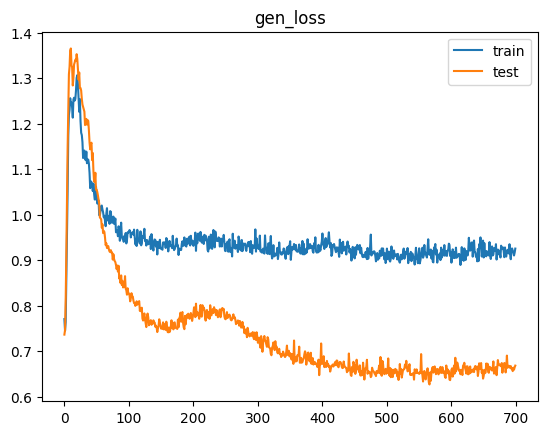

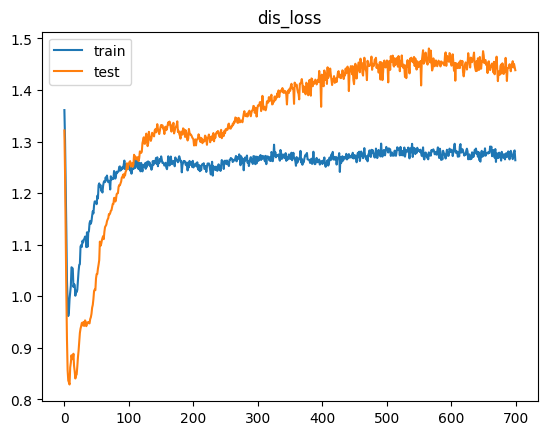

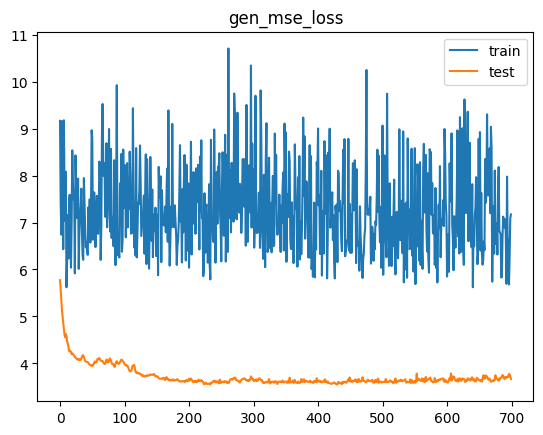

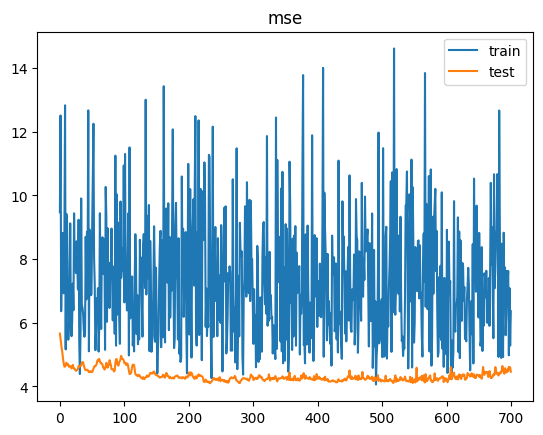

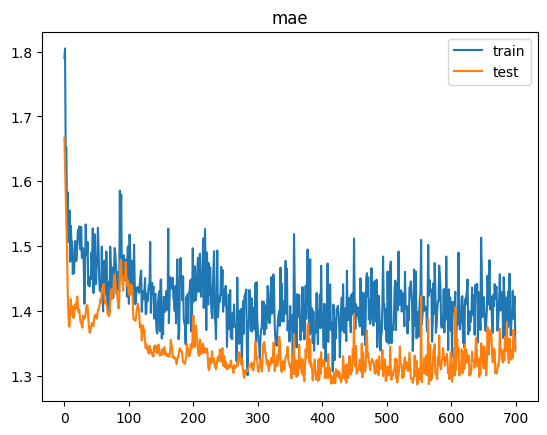

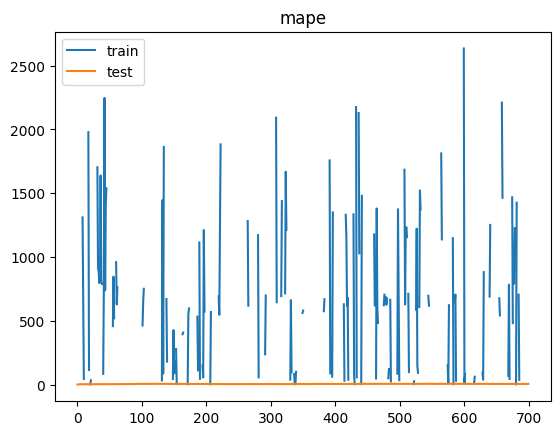

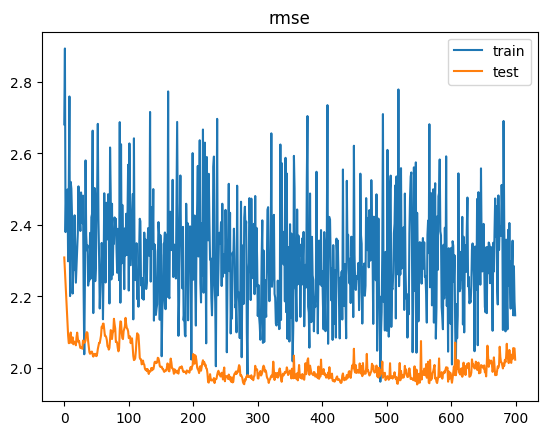

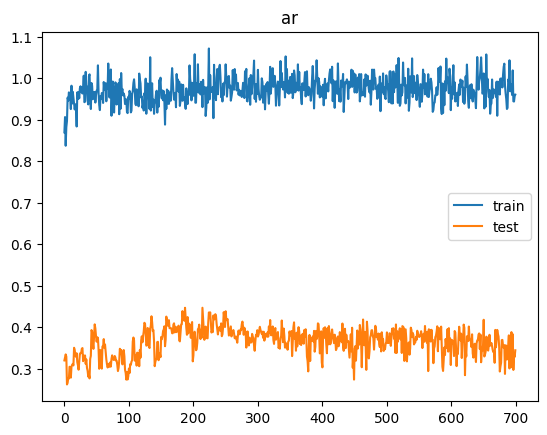

2/2 [==============================] - 0s 2ms/step


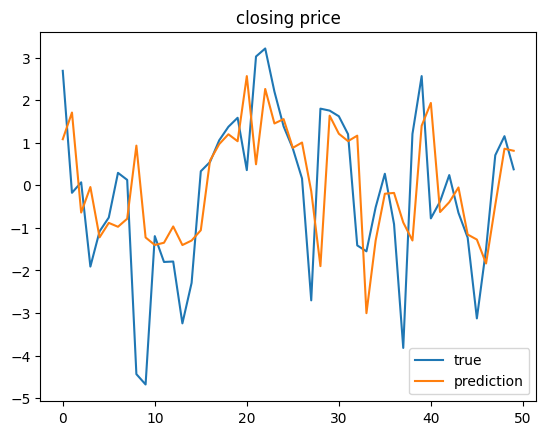

[MSE Baseline] train: 6.797525198506461  test: 4.137918162168212
Delta time with epochs = 700: 0:08:03.133996
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 simple_rnn_3 (

Time for epoch 53 is 0.7085998058319092 sec Generator Loss: 1.0868127346038818,  Discriminator_loss: 1.1631181240081787
Time for epoch 54 is 0.6991453170776367 sec Generator Loss: 1.0665208101272583,  Discriminator_loss: 1.1733360290527344
Time for epoch 55 is 0.763047456741333 sec Generator Loss: 1.056799292564392,  Discriminator_loss: 1.1899478435516357
Time for epoch 56 is 0.8370270729064941 sec Generator Loss: 1.070676326751709,  Discriminator_loss: 1.1783307790756226
Time for epoch 57 is 0.6477468013763428 sec Generator Loss: 1.0578125715255737,  Discriminator_loss: 1.1785143613815308
Time for epoch 58 is 0.6494436264038086 sec Generator Loss: 1.0495398044586182,  Discriminator_loss: 1.1817513704299927
Time for epoch 59 is 0.6503252983093262 sec Generator Loss: 1.0541936159133911,  Discriminator_loss: 1.1828547716140747
Time for epoch 60 is 0.709601640701294 sec Generator Loss: 1.0357344150543213,  Discriminator_loss: 1.2088087797164917
Time for epoch 61 is 0.6684532165527344 sec 

Time for epoch 122 is 0.6421780586242676 sec Generator Loss: 0.9225467443466187,  Discriminator_loss: 1.2626343965530396
Time for epoch 123 is 0.6420443058013916 sec Generator Loss: 0.9298993945121765,  Discriminator_loss: 1.2691503763198853
Time for epoch 124 is 0.6432135105133057 sec Generator Loss: 0.9316482543945312,  Discriminator_loss: 1.2577930688858032
Time for epoch 125 is 0.6635434627532959 sec Generator Loss: 0.915153980255127,  Discriminator_loss: 1.2714238166809082
Time for epoch 126 is 0.6731510162353516 sec Generator Loss: 0.909623920917511,  Discriminator_loss: 1.2583448886871338
Time for epoch 127 is 0.6477289199829102 sec Generator Loss: 0.9164032936096191,  Discriminator_loss: 1.2520670890808105
Time for epoch 128 is 0.6379044055938721 sec Generator Loss: 0.933230459690094,  Discriminator_loss: 1.253501296043396
Time for epoch 129 is 0.6410880088806152 sec Generator Loss: 0.9437572956085205,  Discriminator_loss: 1.2568405866622925
Time for epoch 130 is 0.642698287963

Time for epoch 191 is 0.7190384864807129 sec Generator Loss: 0.891127347946167,  Discriminator_loss: 1.2730956077575684
Time for epoch 192 is 0.6851174831390381 sec Generator Loss: 0.9035234451293945,  Discriminator_loss: 1.282678246498108
Time for epoch 193 is 0.659320592880249 sec Generator Loss: 0.8972085118293762,  Discriminator_loss: 1.2767211198806763
Time for epoch 194 is 0.6585500240325928 sec Generator Loss: 0.8870854377746582,  Discriminator_loss: 1.285319209098816
Time for epoch 195 is 0.6750226020812988 sec Generator Loss: 0.9189745783805847,  Discriminator_loss: 1.277991533279419
Time for epoch 196 is 0.8003652095794678 sec Generator Loss: 0.8874139189720154,  Discriminator_loss: 1.2851264476776123
Time for epoch 197 is 0.7200579643249512 sec Generator Loss: 0.8987330794334412,  Discriminator_loss: 1.2816699743270874
Time for epoch 198 is 0.6760993003845215 sec Generator Loss: 0.9067780375480652,  Discriminator_loss: 1.2680565118789673
Time for epoch 199 is 0.6753296852111

Time for epoch 259 is 0.6772546768188477 sec Generator Loss: 0.907140851020813,  Discriminator_loss: 1.280685305595398
Time for epoch 260 is 0.6610774993896484 sec Generator Loss: 0.9099177122116089,  Discriminator_loss: 1.2809617519378662
Time for epoch 261 is 0.6569781303405762 sec Generator Loss: 0.8942053914070129,  Discriminator_loss: 1.287651538848877
Time for epoch 262 is 0.6778857707977295 sec Generator Loss: 0.9002794623374939,  Discriminator_loss: 1.2769662141799927
Time for epoch 263 is 0.6708719730377197 sec Generator Loss: 0.9427579045295715,  Discriminator_loss: 1.285784363746643
Time for epoch 264 is 0.6559092998504639 sec Generator Loss: 0.8858081698417664,  Discriminator_loss: 1.2811013460159302
Time for epoch 265 is 0.6567883491516113 sec Generator Loss: 0.8898484706878662,  Discriminator_loss: 1.2788563966751099
Time for epoch 266 is 0.64404296875 sec Generator Loss: 0.8873955607414246,  Discriminator_loss: 1.2769746780395508
Time for epoch 267 is 0.6441192626953125 

Time for epoch 327 is 0.6983528137207031 sec Generator Loss: 0.9145796895027161,  Discriminator_loss: 1.2782357931137085
Time for epoch 328 is 0.7036724090576172 sec Generator Loss: 0.9220670461654663,  Discriminator_loss: 1.2906980514526367
Time for epoch 329 is 0.7892463207244873 sec Generator Loss: 0.931353747844696,  Discriminator_loss: 1.2733982801437378
Time for epoch 330 is 0.7827329635620117 sec Generator Loss: 0.9195442199707031,  Discriminator_loss: 1.2728339433670044
Time for epoch 331 is 0.7930097579956055 sec Generator Loss: 0.9055508375167847,  Discriminator_loss: 1.2901767492294312
Time for epoch 332 is 0.8573246002197266 sec Generator Loss: 0.9187789559364319,  Discriminator_loss: 1.2717000246047974
Time for epoch 333 is 0.8197407722473145 sec Generator Loss: 0.9072744250297546,  Discriminator_loss: 1.2750916481018066
Time for epoch 334 is 0.7692675590515137 sec Generator Loss: 0.905986487865448,  Discriminator_loss: 1.2939541339874268
Time for epoch 335 is 0.9277498722

Time for epoch 395 is 0.6995012760162354 sec Generator Loss: 0.9134259819984436,  Discriminator_loss: 1.270685076713562
Time for epoch 396 is 0.6826503276824951 sec Generator Loss: 0.9352556467056274,  Discriminator_loss: 1.2662389278411865
Time for epoch 397 is 0.6593871116638184 sec Generator Loss: 0.9199020266532898,  Discriminator_loss: 1.2795408964157104
Time for epoch 398 is 0.6670567989349365 sec Generator Loss: 0.9158761501312256,  Discriminator_loss: 1.27467942237854
Time for epoch 399 is 0.6472692489624023 sec Generator Loss: 0.9045877456665039,  Discriminator_loss: 1.2775236368179321
Time for epoch 400 is 0.6584908962249756 sec Generator Loss: 0.9209377765655518,  Discriminator_loss: 1.2772282361984253
Time for epoch 401 is 0.6548526287078857 sec Generator Loss: 0.9124705195426941,  Discriminator_loss: 1.2701956033706665
Time for epoch 402 is 0.6804089546203613 sec Generator Loss: 0.9177044034004211,  Discriminator_loss: 1.2749860286712646
Time for epoch 403 is 0.66017246246

Time for epoch 464 is 0.6748321056365967 sec Generator Loss: 0.9073495864868164,  Discriminator_loss: 1.2762678861618042
Time for epoch 465 is 0.7866549491882324 sec Generator Loss: 0.919436514377594,  Discriminator_loss: 1.2677732706069946
Time for epoch 466 is 1.3602795600891113 sec Generator Loss: 0.9114486575126648,  Discriminator_loss: 1.2599436044692993
Time for epoch 467 is 0.6871190071105957 sec Generator Loss: 0.9146782755851746,  Discriminator_loss: 1.2788982391357422
Time for epoch 468 is 0.6908316612243652 sec Generator Loss: 0.9183277487754822,  Discriminator_loss: 1.2722067832946777
Time for epoch 469 is 0.6700525283813477 sec Generator Loss: 0.9170270562171936,  Discriminator_loss: 1.2711478471755981
Time for epoch 470 is 0.6947300434112549 sec Generator Loss: 0.9194772839546204,  Discriminator_loss: 1.2698758840560913
Time for epoch 471 is 0.8164520263671875 sec Generator Loss: 0.9212482571601868,  Discriminator_loss: 1.2813671827316284
Time for epoch 472 is 0.864917516

Time for epoch 533 is 0.6439635753631592 sec Generator Loss: 0.9215971231460571,  Discriminator_loss: 1.2696696519851685
Time for epoch 534 is 0.6425361633300781 sec Generator Loss: 0.9070945978164673,  Discriminator_loss: 1.2821435928344727
Time for epoch 535 is 0.6713857650756836 sec Generator Loss: 0.9207369089126587,  Discriminator_loss: 1.2679381370544434
Time for epoch 536 is 0.8392107486724854 sec Generator Loss: 0.9216626286506653,  Discriminator_loss: 1.264586091041565
Time for epoch 537 is 0.7838096618652344 sec Generator Loss: 0.9370958805084229,  Discriminator_loss: 1.2707887887954712
Time for epoch 538 is 0.9399991035461426 sec Generator Loss: 0.9186005592346191,  Discriminator_loss: 1.2609800100326538
Time for epoch 539 is 0.8995695114135742 sec Generator Loss: 0.9206834435462952,  Discriminator_loss: 1.2665295600891113
Time for epoch 540 is 0.9159994125366211 sec Generator Loss: 0.9290463328361511,  Discriminator_loss: 1.268228530883789
Time for epoch 541 is 0.7558851242

Time for epoch 601 is 0.6489231586456299 sec Generator Loss: 0.9359392523765564,  Discriminator_loss: 1.2576528787612915
Time for epoch 602 is 0.7021443843841553 sec Generator Loss: 0.9300253987312317,  Discriminator_loss: 1.2627668380737305
Time for epoch 603 is 0.657372236251831 sec Generator Loss: 0.9335753917694092,  Discriminator_loss: 1.2561410665512085
Time for epoch 604 is 0.6513142585754395 sec Generator Loss: 0.9361072778701782,  Discriminator_loss: 1.258996844291687
Time for epoch 605 is 0.6517550945281982 sec Generator Loss: 0.9162256717681885,  Discriminator_loss: 1.2610692977905273
Time for epoch 606 is 0.6501119136810303 sec Generator Loss: 0.9327108860015869,  Discriminator_loss: 1.2765525579452515
Time for epoch 607 is 0.686500072479248 sec Generator Loss: 0.9162399768829346,  Discriminator_loss: 1.2667635679244995
Time for epoch 608 is 0.7452218532562256 sec Generator Loss: 0.9513846635818481,  Discriminator_loss: 1.2603838443756104
Time for epoch 609 is 0.67115569114

Time for epoch 670 is 0.6896371841430664 sec Generator Loss: 0.9389708638191223,  Discriminator_loss: 1.2504596710205078
Time for epoch 671 is 0.6810266971588135 sec Generator Loss: 0.9241518974304199,  Discriminator_loss: 1.257326602935791
Time for epoch 672 is 0.6532433032989502 sec Generator Loss: 0.9447742104530334,  Discriminator_loss: 1.2503267526626587
Time for epoch 673 is 0.6511106491088867 sec Generator Loss: 0.928834080696106,  Discriminator_loss: 1.2663993835449219
Time for epoch 674 is 0.7001228332519531 sec Generator Loss: 0.935498833656311,  Discriminator_loss: 1.2635939121246338
Time for epoch 675 is 0.6785318851470947 sec Generator Loss: 0.9350043535232544,  Discriminator_loss: 1.253171682357788
Time for epoch 676 is 0.6805307865142822 sec Generator Loss: 0.9362487196922302,  Discriminator_loss: 1.2608730792999268
Time for epoch 677 is 0.6631085872650146 sec Generator Loss: 0.9268261790275574,  Discriminator_loss: 1.272584080696106
Time for epoch 678 is 0.6556682586669

Time for epoch 739 is 0.6481525897979736 sec Generator Loss: 0.9252992868423462,  Discriminator_loss: 1.2728899717330933
Time for epoch 740 is 0.6594357490539551 sec Generator Loss: 0.9545246958732605,  Discriminator_loss: 1.2424464225769043
Time for epoch 741 is 0.6894493103027344 sec Generator Loss: 0.9468098282814026,  Discriminator_loss: 1.2460414171218872
Time for epoch 742 is 0.6549110412597656 sec Generator Loss: 0.9561276435852051,  Discriminator_loss: 1.2556312084197998
Time for epoch 743 is 0.6557981967926025 sec Generator Loss: 0.9432337284088135,  Discriminator_loss: 1.2543623447418213
Time for epoch 744 is 0.6453070640563965 sec Generator Loss: 0.9640479683876038,  Discriminator_loss: 1.2419233322143555
Time for epoch 745 is 0.6683599948883057 sec Generator Loss: 0.9706218242645264,  Discriminator_loss: 1.2445951700210571
Time for epoch 746 is 0.6487035751342773 sec Generator Loss: 0.9482877850532532,  Discriminator_loss: 1.2582303285598755
Time for epoch 747 is 0.65244364

Time for epoch 808 is 0.6756546497344971 sec Generator Loss: 0.9852104783058167,  Discriminator_loss: 1.2406015396118164
Time for epoch 809 is 0.651057243347168 sec Generator Loss: 0.9343897700309753,  Discriminator_loss: 1.252246379852295
Time for epoch 810 is 0.700697660446167 sec Generator Loss: 0.9439318180084229,  Discriminator_loss: 1.2539021968841553
Time for epoch 811 is 0.6608076095581055 sec Generator Loss: 0.945502519607544,  Discriminator_loss: 1.254217505455017
Time for epoch 812 is 0.6554234027862549 sec Generator Loss: 0.9409650564193726,  Discriminator_loss: 1.2451691627502441
Time for epoch 813 is 0.6567449569702148 sec Generator Loss: 0.9391191005706787,  Discriminator_loss: 1.2558296918869019
Time for epoch 814 is 0.6549441814422607 sec Generator Loss: 0.9488070011138916,  Discriminator_loss: 1.2488784790039062
Time for epoch 815 is 0.6572384834289551 sec Generator Loss: 0.9472585320472717,  Discriminator_loss: 1.2452008724212646
Time for epoch 816 is 0.6527695655822

Time for epoch 877 is 0.668999433517456 sec Generator Loss: 0.9525310397148132,  Discriminator_loss: 1.2489771842956543
Time for epoch 878 is 0.6670932769775391 sec Generator Loss: 0.9545145630836487,  Discriminator_loss: 1.2494887113571167
Time for epoch 879 is 0.6807067394256592 sec Generator Loss: 0.935059130191803,  Discriminator_loss: 1.2604100704193115
Time for epoch 880 is 0.6517467498779297 sec Generator Loss: 0.9430482387542725,  Discriminator_loss: 1.2479465007781982
Time for epoch 881 is 0.6531367301940918 sec Generator Loss: 0.9460578560829163,  Discriminator_loss: 1.2458391189575195
Time for epoch 882 is 0.6704261302947998 sec Generator Loss: 0.9695804119110107,  Discriminator_loss: 1.2444183826446533
Time for epoch 883 is 0.6541690826416016 sec Generator Loss: 0.9651222825050354,  Discriminator_loss: 1.2575716972351074
Time for epoch 884 is 0.6598761081695557 sec Generator Loss: 0.9795183539390564,  Discriminator_loss: 1.2547968626022339
Time for epoch 885 is 0.6549766063

Time for epoch 945 is 0.6564948558807373 sec Generator Loss: 0.9703700542449951,  Discriminator_loss: 1.2432222366333008
Time for epoch 946 is 0.6910467147827148 sec Generator Loss: 0.9776577353477478,  Discriminator_loss: 1.247155785560608
Time for epoch 947 is 0.6669752597808838 sec Generator Loss: 0.9477837085723877,  Discriminator_loss: 1.2287089824676514
Time for epoch 948 is 0.6540870666503906 sec Generator Loss: 0.9627294540405273,  Discriminator_loss: 1.2417644262313843
Time for epoch 949 is 0.6607296466827393 sec Generator Loss: 0.9659170508384705,  Discriminator_loss: 1.2336673736572266
Time for epoch 950 is 0.6525928974151611 sec Generator Loss: 0.9660694003105164,  Discriminator_loss: 1.2401589155197144


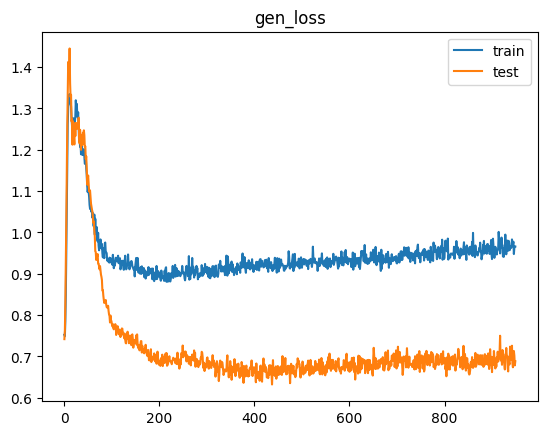

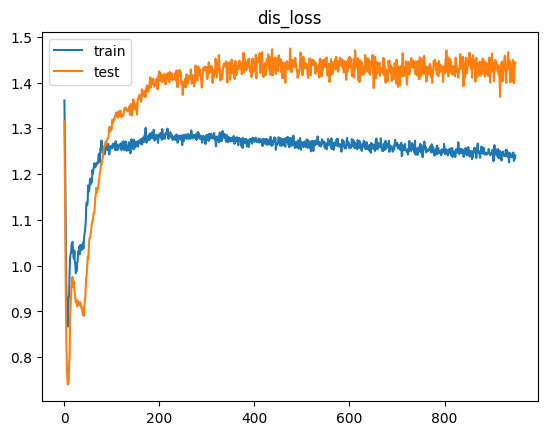

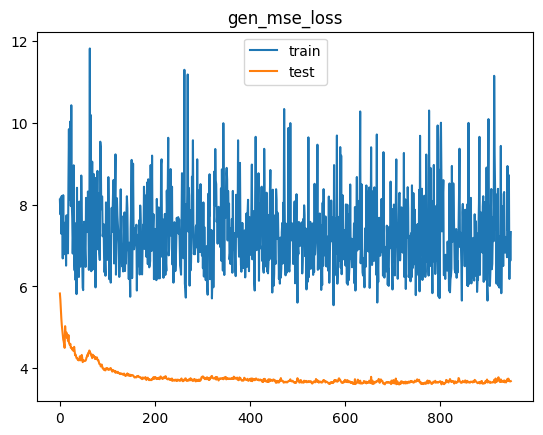

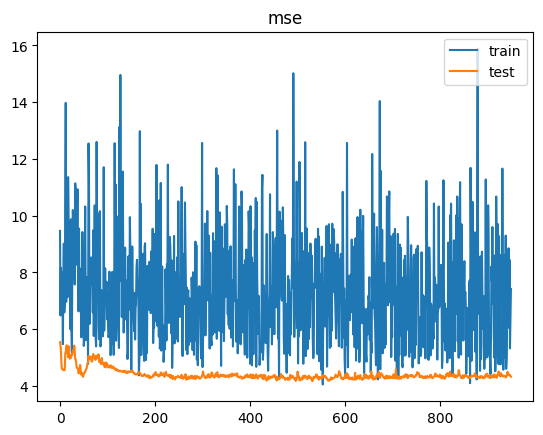

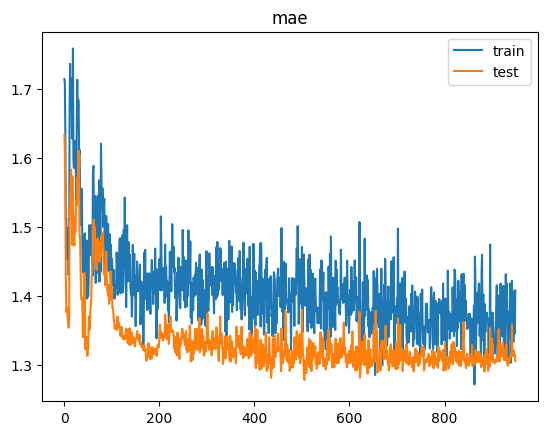

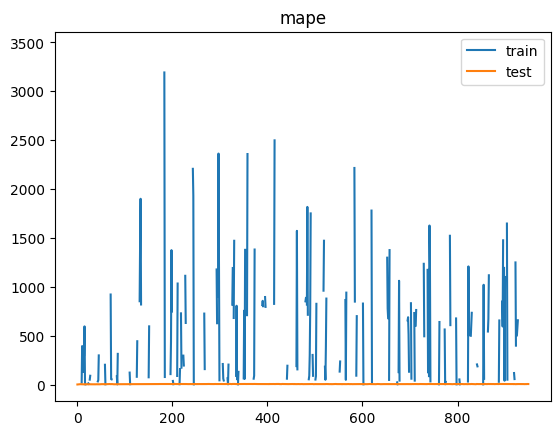

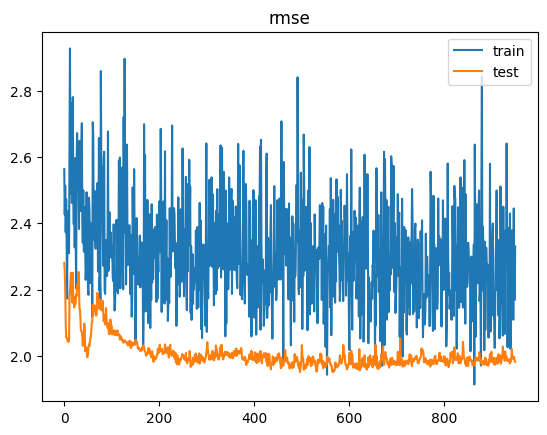

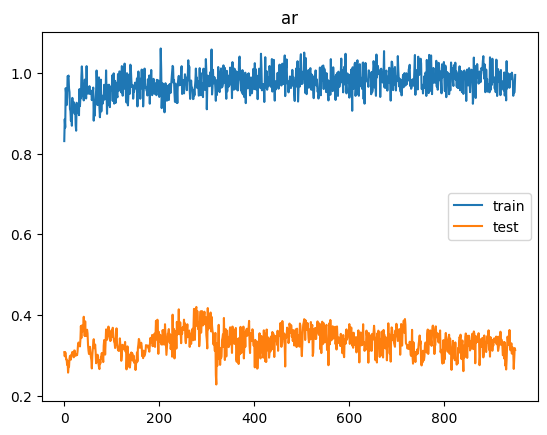

2/2 [==============================] - 0s 3ms/step


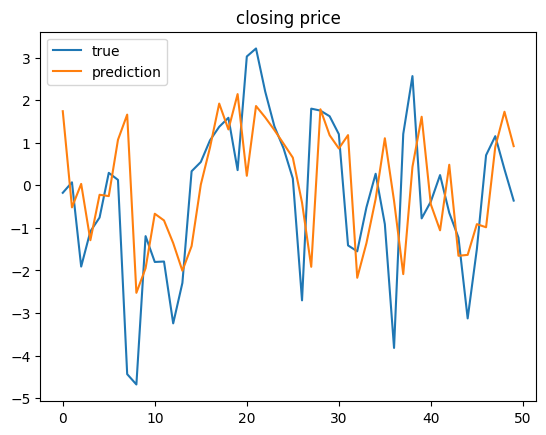

[MSE Baseline] train: 5.738154742608606  test: 4.1521541466081695
Delta time with epochs = 950: 0:11:05.460386


In [20]:
for epochs in [700, 950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10)                210       
                                                           

Time for epoch 53 is 0.6577811241149902 sec Generator Loss: 1.0509968996047974,  Discriminator_loss: 1.153755784034729
Time for epoch 54 is 0.655524730682373 sec Generator Loss: 1.0465620756149292,  Discriminator_loss: 1.1608374118804932
Time for epoch 55 is 0.6599798202514648 sec Generator Loss: 1.052952527999878,  Discriminator_loss: 1.1475348472595215
Time for epoch 56 is 0.6552338600158691 sec Generator Loss: 1.0592131614685059,  Discriminator_loss: 1.14211106300354
Time for epoch 57 is 0.6605873107910156 sec Generator Loss: 1.0600334405899048,  Discriminator_loss: 1.1509227752685547
Time for epoch 58 is 0.6513144969940186 sec Generator Loss: 1.0490987300872803,  Discriminator_loss: 1.1526494026184082
Time for epoch 59 is 0.6507318019866943 sec Generator Loss: 1.0489637851715088,  Discriminator_loss: 1.135446548461914
Time for epoch 60 is 0.7289719581604004 sec Generator Loss: 1.048062801361084,  Discriminator_loss: 1.1394623517990112
Time for epoch 61 is 0.7095928192138672 sec Gen

Time for epoch 122 is 0.6721827983856201 sec Generator Loss: 0.9482538104057312,  Discriminator_loss: 1.2618001699447632
Time for epoch 123 is 0.6514747142791748 sec Generator Loss: 0.9472119808197021,  Discriminator_loss: 1.2591252326965332
Time for epoch 124 is 0.6606836318969727 sec Generator Loss: 0.9501873254776001,  Discriminator_loss: 1.2566485404968262
Time for epoch 125 is 0.6585085391998291 sec Generator Loss: 0.9428648948669434,  Discriminator_loss: 1.2509475946426392
Time for epoch 126 is 0.6507694721221924 sec Generator Loss: 0.9679914712905884,  Discriminator_loss: 1.2507638931274414
Time for epoch 127 is 0.64851975440979 sec Generator Loss: 0.952552855014801,  Discriminator_loss: 1.2645350694656372
Time for epoch 128 is 0.651322603225708 sec Generator Loss: 0.9567273259162903,  Discriminator_loss: 1.25753915309906
Time for epoch 129 is 0.6690545082092285 sec Generator Loss: 0.9340155720710754,  Discriminator_loss: 1.245093584060669
Time for epoch 130 is 0.660840988159179

Time for epoch 191 is 0.6551153659820557 sec Generator Loss: 0.9315629601478577,  Discriminator_loss: 1.2646249532699585
Time for epoch 192 is 0.6566071510314941 sec Generator Loss: 0.9328781366348267,  Discriminator_loss: 1.253913402557373
Time for epoch 193 is 0.6528234481811523 sec Generator Loss: 0.9522210359573364,  Discriminator_loss: 1.2606428861618042
Time for epoch 194 is 0.6652247905731201 sec Generator Loss: 0.9144958257675171,  Discriminator_loss: 1.262914776802063
Time for epoch 195 is 0.67380690574646 sec Generator Loss: 0.9154610633850098,  Discriminator_loss: 1.2622969150543213
Time for epoch 196 is 0.6611433029174805 sec Generator Loss: 0.9500194191932678,  Discriminator_loss: 1.2637947797775269
Time for epoch 197 is 0.7011373043060303 sec Generator Loss: 0.9236800670623779,  Discriminator_loss: 1.2694439888000488
Time for epoch 198 is 0.6623988151550293 sec Generator Loss: 0.921700656414032,  Discriminator_loss: 1.2796756029129028
Time for epoch 199 is 0.6626665592193

Time for epoch 259 is 0.6660745143890381 sec Generator Loss: 0.9205202460289001,  Discriminator_loss: 1.2649083137512207
Time for epoch 260 is 0.6651053428649902 sec Generator Loss: 0.9137428998947144,  Discriminator_loss: 1.2543139457702637
Time for epoch 261 is 0.6664013862609863 sec Generator Loss: 0.9435855150222778,  Discriminator_loss: 1.246875286102295
Time for epoch 262 is 0.6630373001098633 sec Generator Loss: 0.9171518683433533,  Discriminator_loss: 1.2561849355697632
Time for epoch 263 is 0.6679277420043945 sec Generator Loss: 0.9203927516937256,  Discriminator_loss: 1.2616736888885498
Time for epoch 264 is 0.6679172515869141 sec Generator Loss: 0.9414095878601074,  Discriminator_loss: 1.2596668004989624
Time for epoch 265 is 0.6685042381286621 sec Generator Loss: 0.9305686354637146,  Discriminator_loss: 1.2563347816467285
Time for epoch 266 is 0.6612803936004639 sec Generator Loss: 0.917731523513794,  Discriminator_loss: 1.2615841627120972
Time for epoch 267 is 0.6626267433

Time for epoch 327 is 0.6939654350280762 sec Generator Loss: 0.9160640835762024,  Discriminator_loss: 1.2671774625778198
Time for epoch 328 is 0.6948680877685547 sec Generator Loss: 0.9202665686607361,  Discriminator_loss: 1.2675418853759766
Time for epoch 329 is 0.7244329452514648 sec Generator Loss: 0.9382283091545105,  Discriminator_loss: 1.2662022113800049
Time for epoch 330 is 0.6903996467590332 sec Generator Loss: 0.9349656701087952,  Discriminator_loss: 1.2791812419891357
Time for epoch 331 is 0.6876904964447021 sec Generator Loss: 0.9199402928352356,  Discriminator_loss: 1.2654649019241333
Time for epoch 332 is 0.7195250988006592 sec Generator Loss: 0.9093371033668518,  Discriminator_loss: 1.2693605422973633
Time for epoch 333 is 0.6802163124084473 sec Generator Loss: 0.904182493686676,  Discriminator_loss: 1.2727514505386353
Time for epoch 334 is 0.6642632484436035 sec Generator Loss: 0.9265150427818298,  Discriminator_loss: 1.2700459957122803
Time for epoch 335 is 0.696555614

Time for epoch 396 is 0.6640098094940186 sec Generator Loss: 0.929585874080658,  Discriminator_loss: 1.2779980897903442
Time for epoch 397 is 0.6778068542480469 sec Generator Loss: 0.9258873462677002,  Discriminator_loss: 1.264939308166504
Time for epoch 398 is 0.6681344509124756 sec Generator Loss: 0.9128979444503784,  Discriminator_loss: 1.2727211713790894
Time for epoch 399 is 0.6676650047302246 sec Generator Loss: 0.9176437258720398,  Discriminator_loss: 1.2606995105743408
Time for epoch 400 is 0.6675338745117188 sec Generator Loss: 0.9159265160560608,  Discriminator_loss: 1.259802222251892
Time for epoch 401 is 0.666090726852417 sec Generator Loss: 0.9313085675239563,  Discriminator_loss: 1.2603996992111206
Time for epoch 402 is 0.6596202850341797 sec Generator Loss: 0.917218029499054,  Discriminator_loss: 1.2581164836883545
Time for epoch 403 is 0.6645784378051758 sec Generator Loss: 0.9227574467658997,  Discriminator_loss: 1.2735546827316284
Time for epoch 404 is 0.6650309562683

Time for epoch 465 is 0.6661059856414795 sec Generator Loss: 0.9309934377670288,  Discriminator_loss: 1.2661685943603516
Time for epoch 466 is 0.6652750968933105 sec Generator Loss: 0.9216774702072144,  Discriminator_loss: 1.2527931928634644
Time for epoch 467 is 0.6727194786071777 sec Generator Loss: 0.9140120148658752,  Discriminator_loss: 1.2661044597625732
Time for epoch 468 is 0.663975715637207 sec Generator Loss: 0.9377530217170715,  Discriminator_loss: 1.2639816999435425
Time for epoch 469 is 0.6649401187896729 sec Generator Loss: 0.9358074069023132,  Discriminator_loss: 1.261335015296936
Time for epoch 470 is 0.664691686630249 sec Generator Loss: 0.944191038608551,  Discriminator_loss: 1.2615901231765747
Time for epoch 471 is 0.6604511737823486 sec Generator Loss: 0.9296050071716309,  Discriminator_loss: 1.2613379955291748
Time for epoch 472 is 0.6552197933197021 sec Generator Loss: 0.921639621257782,  Discriminator_loss: 1.265142560005188
Time for epoch 473 is 0.66797137260437

Time for epoch 533 is 0.666511058807373 sec Generator Loss: 0.9515653252601624,  Discriminator_loss: 1.2537740468978882
Time for epoch 534 is 0.667407751083374 sec Generator Loss: 0.9373729228973389,  Discriminator_loss: 1.2532283067703247
Time for epoch 535 is 0.6639432907104492 sec Generator Loss: 0.9199519753456116,  Discriminator_loss: 1.2678020000457764
Time for epoch 536 is 0.6706986427307129 sec Generator Loss: 0.9420913457870483,  Discriminator_loss: 1.2542166709899902
Time for epoch 537 is 0.6630547046661377 sec Generator Loss: 0.9222228527069092,  Discriminator_loss: 1.2678078413009644
Time for epoch 538 is 0.6932311058044434 sec Generator Loss: 0.9564626216888428,  Discriminator_loss: 1.2606374025344849
Time for epoch 539 is 0.68243408203125 sec Generator Loss: 0.9363507628440857,  Discriminator_loss: 1.2564623355865479
Time for epoch 540 is 0.6644449234008789 sec Generator Loss: 0.9289451241493225,  Discriminator_loss: 1.261736273765564
Time for epoch 541 is 0.6705453395843

Time for epoch 602 is 0.8655276298522949 sec Generator Loss: 0.9458074569702148,  Discriminator_loss: 1.2652530670166016
Time for epoch 603 is 0.7035496234893799 sec Generator Loss: 0.944503664970398,  Discriminator_loss: 1.2640588283538818
Time for epoch 604 is 0.7057993412017822 sec Generator Loss: 0.9458612203598022,  Discriminator_loss: 1.2576128244400024
Time for epoch 605 is 0.7440829277038574 sec Generator Loss: 0.9277252554893494,  Discriminator_loss: 1.2574023008346558
Time for epoch 606 is 0.7168331146240234 sec Generator Loss: 0.9399355053901672,  Discriminator_loss: 1.2503643035888672
Time for epoch 607 is 0.6784322261810303 sec Generator Loss: 0.9396383762359619,  Discriminator_loss: 1.2517095804214478
Time for epoch 608 is 0.6779775619506836 sec Generator Loss: 0.9625499248504639,  Discriminator_loss: 1.2520157098770142
Time for epoch 609 is 0.6803803443908691 sec Generator Loss: 0.9311985373497009,  Discriminator_loss: 1.255752444267273
Time for epoch 610 is 0.6776492595

Time for epoch 671 is 0.7361338138580322 sec Generator Loss: 0.9386357069015503,  Discriminator_loss: 1.26051664352417
Time for epoch 672 is 0.7157304286956787 sec Generator Loss: 0.9393550157546997,  Discriminator_loss: 1.2579002380371094
Time for epoch 673 is 0.6904921531677246 sec Generator Loss: 0.9591442942619324,  Discriminator_loss: 1.253924012184143
Time for epoch 674 is 0.7381613254547119 sec Generator Loss: 0.9409846663475037,  Discriminator_loss: 1.2653913497924805
Time for epoch 675 is 0.7585036754608154 sec Generator Loss: 0.9555164575576782,  Discriminator_loss: 1.2510476112365723
Time for epoch 676 is 0.7677643299102783 sec Generator Loss: 0.9285863041877747,  Discriminator_loss: 1.2589600086212158
Time for epoch 677 is 0.7547578811645508 sec Generator Loss: 0.9436799883842468,  Discriminator_loss: 1.2468034029006958
Time for epoch 678 is 0.7904837131500244 sec Generator Loss: 0.9209827184677124,  Discriminator_loss: 1.2636067867279053
Time for epoch 679 is 0.71387362480

Time for epoch 740 is 0.7048244476318359 sec Generator Loss: 0.9456623792648315,  Discriminator_loss: 1.2657910585403442
Time for epoch 741 is 0.7041168212890625 sec Generator Loss: 0.9481188058853149,  Discriminator_loss: 1.2505977153778076
Time for epoch 742 is 0.706761360168457 sec Generator Loss: 0.9540884494781494,  Discriminator_loss: 1.2535247802734375
Time for epoch 743 is 1.665402889251709 sec Generator Loss: 0.9560138583183289,  Discriminator_loss: 1.2395554780960083
Time for epoch 744 is 0.7002537250518799 sec Generator Loss: 0.969417929649353,  Discriminator_loss: 1.250063180923462
Time for epoch 745 is 0.7066230773925781 sec Generator Loss: 0.9628875851631165,  Discriminator_loss: 1.2403144836425781
Time for epoch 746 is 0.7088625431060791 sec Generator Loss: 0.9692474007606506,  Discriminator_loss: 1.2445472478866577
Time for epoch 747 is 0.696014404296875 sec Generator Loss: 0.9554728865623474,  Discriminator_loss: 1.255859136581421
Time for epoch 748 is 0.69663214683532

Time for epoch 809 is 0.8567085266113281 sec Generator Loss: 0.9650682806968689,  Discriminator_loss: 1.2528603076934814
Time for epoch 810 is 0.7485969066619873 sec Generator Loss: 0.9425888061523438,  Discriminator_loss: 1.2504373788833618
Time for epoch 811 is 0.7591662406921387 sec Generator Loss: 0.9710102081298828,  Discriminator_loss: 1.2440887689590454
Time for epoch 812 is 0.7950525283813477 sec Generator Loss: 0.9610611796379089,  Discriminator_loss: 1.2461661100387573
Time for epoch 813 is 0.7737815380096436 sec Generator Loss: 0.9750953912734985,  Discriminator_loss: 1.2361938953399658
Time for epoch 814 is 0.703977108001709 sec Generator Loss: 0.9481459259986877,  Discriminator_loss: 1.2556982040405273
Time for epoch 815 is 0.6845033168792725 sec Generator Loss: 0.9564915895462036,  Discriminator_loss: 1.2470719814300537
Time for epoch 816 is 0.697110652923584 sec Generator Loss: 0.9469833970069885,  Discriminator_loss: 1.2566899061203003
Time for epoch 817 is 0.6826095581

Time for epoch 877 is 0.872028112411499 sec Generator Loss: 0.9519415497779846,  Discriminator_loss: 1.2453949451446533
Time for epoch 878 is 0.8340725898742676 sec Generator Loss: 0.9569292068481445,  Discriminator_loss: 1.2423690557479858
Time for epoch 879 is 0.7774772644042969 sec Generator Loss: 0.9680320024490356,  Discriminator_loss: 1.2405967712402344
Time for epoch 880 is 0.7444348335266113 sec Generator Loss: 0.9552847743034363,  Discriminator_loss: 1.2440576553344727
Time for epoch 881 is 0.7554929256439209 sec Generator Loss: 0.9670048952102661,  Discriminator_loss: 1.2461875677108765
Time for epoch 882 is 0.7262692451477051 sec Generator Loss: 0.963618278503418,  Discriminator_loss: 1.2400038242340088
Time for epoch 883 is 0.7151422500610352 sec Generator Loss: 0.949193000793457,  Discriminator_loss: 1.246996521949768
Time for epoch 884 is 0.7620840072631836 sec Generator Loss: 0.9577245712280273,  Discriminator_loss: 1.2428126335144043
Time for epoch 885 is 0.708003044128

Time for epoch 945 is 0.7183778285980225 sec Generator Loss: 0.9772043228149414,  Discriminator_loss: 1.242121696472168
Time for epoch 946 is 0.7433958053588867 sec Generator Loss: 0.9542638659477234,  Discriminator_loss: 1.2366690635681152
Time for epoch 947 is 0.6806025505065918 sec Generator Loss: 0.9388383030891418,  Discriminator_loss: 1.2604594230651855
Time for epoch 948 is 0.6675901412963867 sec Generator Loss: 0.9671657085418701,  Discriminator_loss: 1.2342181205749512
Time for epoch 949 is 0.7353134155273438 sec Generator Loss: 0.9577246308326721,  Discriminator_loss: 1.2436976432800293
Time for epoch 950 is 0.7402949333190918 sec Generator Loss: 0.9531316757202148,  Discriminator_loss: 1.2421077489852905
Time for epoch 951 is 0.6778247356414795 sec Generator Loss: 0.9615655541419983,  Discriminator_loss: 1.2410650253295898
Time for epoch 952 is 0.753471851348877 sec Generator Loss: 0.9805030822753906,  Discriminator_loss: 1.2476214170455933
Time for epoch 953 is 0.6785218715

Time for epoch 1013 is 0.7433171272277832 sec Generator Loss: 0.9668571949005127,  Discriminator_loss: 1.2503811120986938
Time for epoch 1014 is 0.7649269104003906 sec Generator Loss: 0.9598792195320129,  Discriminator_loss: 1.2458405494689941
Time for epoch 1015 is 0.7237231731414795 sec Generator Loss: 0.9559465050697327,  Discriminator_loss: 1.2415368556976318
Time for epoch 1016 is 0.7099552154541016 sec Generator Loss: 0.973234236240387,  Discriminator_loss: 1.239481806755066
Time for epoch 1017 is 0.6997883319854736 sec Generator Loss: 0.9535638689994812,  Discriminator_loss: 1.265866756439209
Time for epoch 1018 is 0.6924152374267578 sec Generator Loss: 0.9663751125335693,  Discriminator_loss: 1.2549313306808472
Time for epoch 1019 is 0.7104973793029785 sec Generator Loss: 0.946274995803833,  Discriminator_loss: 1.2470417022705078
Time for epoch 1020 is 0.6982245445251465 sec Generator Loss: 0.972545862197876,  Discriminator_loss: 1.2339973449707031
Time for epoch 1021 is 0.7177

Time for epoch 1081 is 0.6787819862365723 sec Generator Loss: 0.9731555581092834,  Discriminator_loss: 1.2413322925567627
Time for epoch 1082 is 0.6739866733551025 sec Generator Loss: 0.9535173177719116,  Discriminator_loss: 1.2480666637420654
Time for epoch 1083 is 0.6727993488311768 sec Generator Loss: 0.9545162320137024,  Discriminator_loss: 1.2600332498550415
Time for epoch 1084 is 0.6761519908905029 sec Generator Loss: 0.9557622075080872,  Discriminator_loss: 1.2512401342391968
Time for epoch 1085 is 0.6760940551757812 sec Generator Loss: 0.9427586197853088,  Discriminator_loss: 1.2546603679656982
Time for epoch 1086 is 0.7210159301757812 sec Generator Loss: 0.9540719389915466,  Discriminator_loss: 1.2305495738983154
Time for epoch 1087 is 0.8298172950744629 sec Generator Loss: 0.9629335999488831,  Discriminator_loss: 1.2450823783874512
Time for epoch 1088 is 0.7349586486816406 sec Generator Loss: 0.962927520275116,  Discriminator_loss: 1.2466535568237305
Time for epoch 1089 is 0.

Time for epoch 1149 is 0.7404754161834717 sec Generator Loss: 0.9703757166862488,  Discriminator_loss: 1.2557154893875122
Time for epoch 1150 is 0.7269315719604492 sec Generator Loss: 0.9548960328102112,  Discriminator_loss: 1.2422223091125488
Time for epoch 1151 is 0.683368444442749 sec Generator Loss: 0.9774070382118225,  Discriminator_loss: 1.2414519786834717
Time for epoch 1152 is 0.6670341491699219 sec Generator Loss: 0.9677819013595581,  Discriminator_loss: 1.253321647644043
Time for epoch 1153 is 0.6743781566619873 sec Generator Loss: 0.9426094889640808,  Discriminator_loss: 1.2488586902618408
Time for epoch 1154 is 0.740487813949585 sec Generator Loss: 0.9706667065620422,  Discriminator_loss: 1.2382867336273193
Time for epoch 1155 is 0.6950082778930664 sec Generator Loss: 0.9656343460083008,  Discriminator_loss: 1.252800464630127
Time for epoch 1156 is 0.7978038787841797 sec Generator Loss: 0.9699562191963196,  Discriminator_loss: 1.2365108728408813
Time for epoch 1157 is 0.707

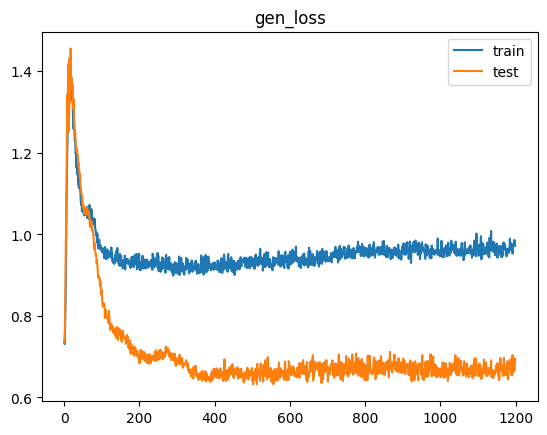

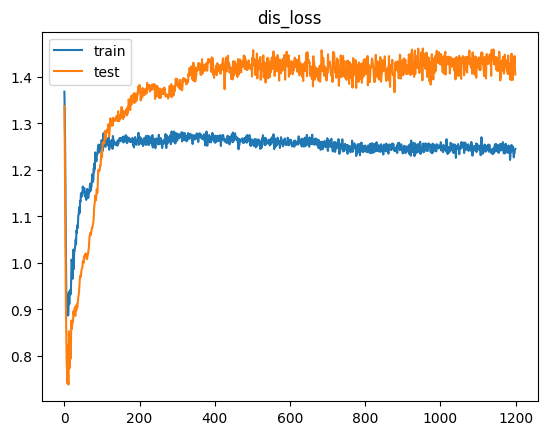

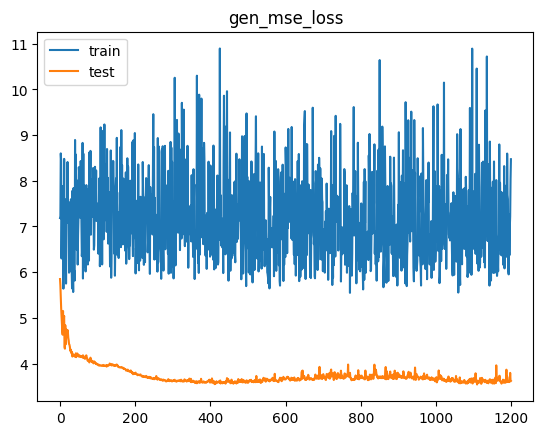

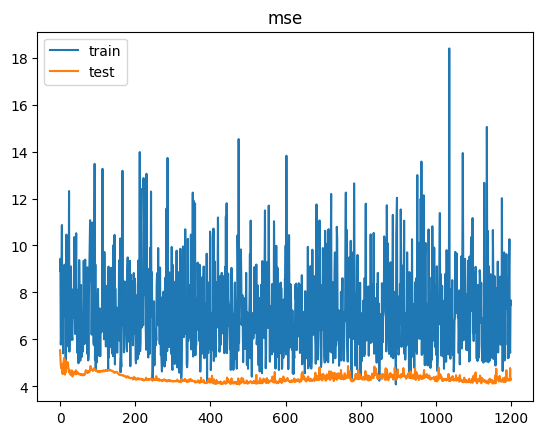

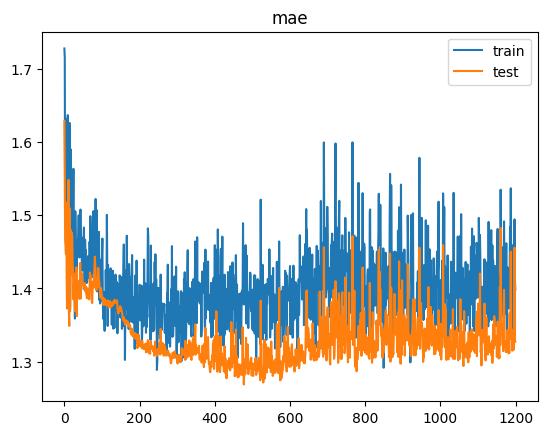

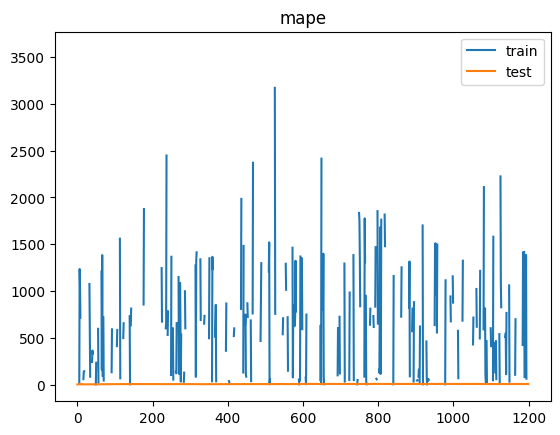

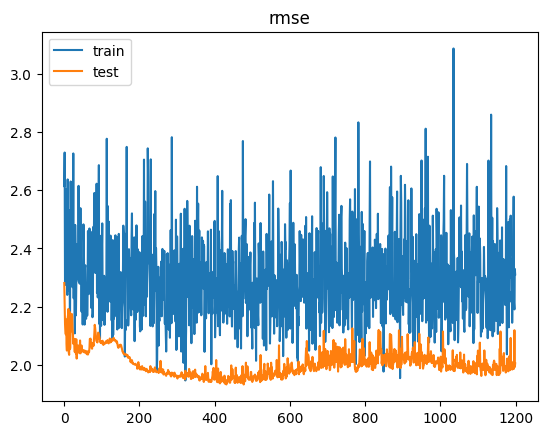

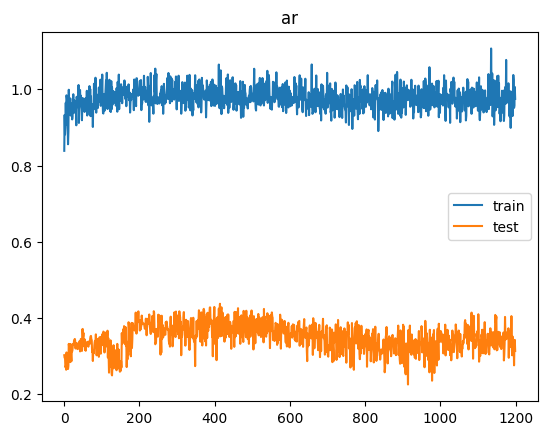

2/2 [==============================] - 0s 2ms/step


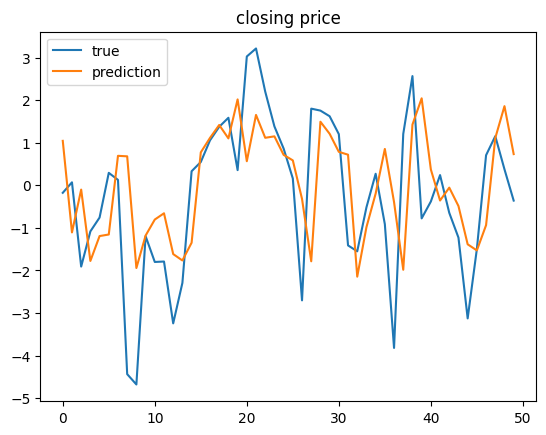

[MSE Baseline] train: 8.978078788368721  test: 4.1521541466081695
Delta time with epochs = 1200: 0:14:09.400109
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_7

Time for epoch 53 is 0.6817014217376709 sec Generator Loss: 1.0797330141067505,  Discriminator_loss: 1.1739447116851807
Time for epoch 54 is 0.6781504154205322 sec Generator Loss: 1.0789904594421387,  Discriminator_loss: 1.1791422367095947
Time for epoch 55 is 0.6884682178497314 sec Generator Loss: 1.053240180015564,  Discriminator_loss: 1.1969313621520996
Time for epoch 56 is 0.6871845722198486 sec Generator Loss: 1.0451061725616455,  Discriminator_loss: 1.2047169208526611
Time for epoch 57 is 0.6758875846862793 sec Generator Loss: 1.03827702999115,  Discriminator_loss: 1.1873935461044312
Time for epoch 58 is 0.6721584796905518 sec Generator Loss: 1.0324938297271729,  Discriminator_loss: 1.2067432403564453
Time for epoch 59 is 0.6735110282897949 sec Generator Loss: 1.0244839191436768,  Discriminator_loss: 1.2034730911254883
Time for epoch 60 is 0.7316102981567383 sec Generator Loss: 1.0220502614974976,  Discriminator_loss: 1.2189124822616577
Time for epoch 61 is 0.7111697196960449 sec

Time for epoch 122 is 0.7241361141204834 sec Generator Loss: 0.9619035720825195,  Discriminator_loss: 1.2592015266418457
Time for epoch 123 is 0.7559061050415039 sec Generator Loss: 0.9508141279220581,  Discriminator_loss: 1.2484350204467773
Time for epoch 124 is 0.7491014003753662 sec Generator Loss: 0.9483861327171326,  Discriminator_loss: 1.2490805387496948
Time for epoch 125 is 0.9188101291656494 sec Generator Loss: 0.9860796928405762,  Discriminator_loss: 1.2461533546447754
Time for epoch 126 is 0.8063135147094727 sec Generator Loss: 0.9654318690299988,  Discriminator_loss: 1.253940224647522
Time for epoch 127 is 0.8035018444061279 sec Generator Loss: 0.9560328125953674,  Discriminator_loss: 1.2532082796096802
Time for epoch 128 is 0.8048160076141357 sec Generator Loss: 0.9752503037452698,  Discriminator_loss: 1.2528862953186035
Time for epoch 129 is 0.6990272998809814 sec Generator Loss: 0.9500644207000732,  Discriminator_loss: 1.2572622299194336
Time for epoch 130 is 0.746000766

Time for epoch 191 is 0.9175572395324707 sec Generator Loss: 0.9184621572494507,  Discriminator_loss: 1.2703860998153687
Time for epoch 192 is 0.840158224105835 sec Generator Loss: 0.9460766315460205,  Discriminator_loss: 1.2793500423431396
Time for epoch 193 is 0.7959423065185547 sec Generator Loss: 0.9413493871688843,  Discriminator_loss: 1.2593320608139038
Time for epoch 194 is 0.8388712406158447 sec Generator Loss: 0.9620062708854675,  Discriminator_loss: 1.267758846282959
Time for epoch 195 is 1.0538661479949951 sec Generator Loss: 0.9584722518920898,  Discriminator_loss: 1.280032992362976
Time for epoch 196 is 0.8141767978668213 sec Generator Loss: 0.9189454317092896,  Discriminator_loss: 1.2826862335205078
Time for epoch 197 is 0.9435579776763916 sec Generator Loss: 0.9439452886581421,  Discriminator_loss: 1.257584810256958
Time for epoch 198 is 1.0277307033538818 sec Generator Loss: 0.9392871856689453,  Discriminator_loss: 1.2678223848342896
Time for epoch 199 is 0.840179920196

Time for epoch 260 is 0.6978888511657715 sec Generator Loss: 0.9169818162918091,  Discriminator_loss: 1.2776488065719604
Time for epoch 261 is 0.7124621868133545 sec Generator Loss: 0.9289053678512573,  Discriminator_loss: 1.2733992338180542
Time for epoch 262 is 0.7009124755859375 sec Generator Loss: 0.9144291877746582,  Discriminator_loss: 1.2666264772415161
Time for epoch 263 is 0.7007684707641602 sec Generator Loss: 0.9554765224456787,  Discriminator_loss: 1.2795989513397217
Time for epoch 264 is 0.714569091796875 sec Generator Loss: 0.9311516880989075,  Discriminator_loss: 1.2679485082626343
Time for epoch 265 is 0.6926755905151367 sec Generator Loss: 0.9385701417922974,  Discriminator_loss: 1.2651067972183228
Time for epoch 266 is 0.6896560192108154 sec Generator Loss: 0.9266177415847778,  Discriminator_loss: 1.2641483545303345
Time for epoch 267 is 0.7123944759368896 sec Generator Loss: 0.9281061291694641,  Discriminator_loss: 1.2654017210006714
Time for epoch 268 is 0.807375192

Time for epoch 328 is 0.7382471561431885 sec Generator Loss: 0.9357768297195435,  Discriminator_loss: 1.2569862604141235
Time for epoch 329 is 0.7164392471313477 sec Generator Loss: 0.9604740738868713,  Discriminator_loss: 1.2647980451583862
Time for epoch 330 is 0.7831015586853027 sec Generator Loss: 0.9438276290893555,  Discriminator_loss: 1.261013388633728
Time for epoch 331 is 0.6987853050231934 sec Generator Loss: 0.9420412182807922,  Discriminator_loss: 1.2536327838897705
Time for epoch 332 is 0.7370691299438477 sec Generator Loss: 0.9449585676193237,  Discriminator_loss: 1.2604902982711792
Time for epoch 333 is 0.7173106670379639 sec Generator Loss: 0.9357354044914246,  Discriminator_loss: 1.2631527185440063
Time for epoch 334 is 0.780803918838501 sec Generator Loss: 0.943272054195404,  Discriminator_loss: 1.2562787532806396
Time for epoch 335 is 0.8051486015319824 sec Generator Loss: 0.9290424585342407,  Discriminator_loss: 1.2660706043243408
Time for epoch 336 is 0.81834292411

Time for epoch 397 is 0.7638325691223145 sec Generator Loss: 0.960818886756897,  Discriminator_loss: 1.2531437873840332
Time for epoch 398 is 0.7738461494445801 sec Generator Loss: 0.9439367055892944,  Discriminator_loss: 1.2566505670547485
Time for epoch 399 is 0.7187283039093018 sec Generator Loss: 0.9750854969024658,  Discriminator_loss: 1.2427502870559692
Time for epoch 400 is 0.7036938667297363 sec Generator Loss: 0.9324524998664856,  Discriminator_loss: 1.2560356855392456
Time for epoch 401 is 0.6951022148132324 sec Generator Loss: 0.9678863286972046,  Discriminator_loss: 1.2442361116409302
Time for epoch 402 is 0.6976351737976074 sec Generator Loss: 0.9635056853294373,  Discriminator_loss: 1.2482846975326538
Time for epoch 403 is 0.6986408233642578 sec Generator Loss: 0.9573540687561035,  Discriminator_loss: 1.2553848028182983
Time for epoch 404 is 0.7772712707519531 sec Generator Loss: 0.9337964653968811,  Discriminator_loss: 1.2564266920089722
Time for epoch 405 is 0.694216012

Time for epoch 465 is 0.7072689533233643 sec Generator Loss: 0.9679504036903381,  Discriminator_loss: 1.2426873445510864
Time for epoch 466 is 0.6953909397125244 sec Generator Loss: 0.953813374042511,  Discriminator_loss: 1.2538790702819824
Time for epoch 467 is 0.7021536827087402 sec Generator Loss: 0.9607588648796082,  Discriminator_loss: 1.2561737298965454
Time for epoch 468 is 0.694826602935791 sec Generator Loss: 0.9655610918998718,  Discriminator_loss: 1.2498713731765747
Time for epoch 469 is 0.713782787322998 sec Generator Loss: 0.956607460975647,  Discriminator_loss: 1.244552731513977
Time for epoch 470 is 0.7005224227905273 sec Generator Loss: 0.9584987759590149,  Discriminator_loss: 1.253426432609558
Time for epoch 471 is 0.6998815536499023 sec Generator Loss: 0.9848048686981201,  Discriminator_loss: 1.2495850324630737
Time for epoch 472 is 0.6987655162811279 sec Generator Loss: 0.97934889793396,  Discriminator_loss: 1.2445579767227173
Time for epoch 473 is 0.698951244354248 

Time for epoch 533 is 0.698922872543335 sec Generator Loss: 0.9642715454101562,  Discriminator_loss: 1.2488967180252075
Time for epoch 534 is 0.7046594619750977 sec Generator Loss: 0.9685095548629761,  Discriminator_loss: 1.2442724704742432
Time for epoch 535 is 0.7862231731414795 sec Generator Loss: 0.9772710204124451,  Discriminator_loss: 1.245310664176941
Time for epoch 536 is 0.7598602771759033 sec Generator Loss: 0.9942370057106018,  Discriminator_loss: 1.2404391765594482
Time for epoch 537 is 0.7587401866912842 sec Generator Loss: 0.9927034378051758,  Discriminator_loss: 1.2528972625732422
Time for epoch 538 is 0.8263397216796875 sec Generator Loss: 0.9782390594482422,  Discriminator_loss: 1.2468228340148926
Time for epoch 539 is 0.7677037715911865 sec Generator Loss: 0.9559308290481567,  Discriminator_loss: 1.2673368453979492
Time for epoch 540 is 0.7087171077728271 sec Generator Loss: 0.9614575505256653,  Discriminator_loss: 1.2494349479675293
Time for epoch 541 is 0.6981935501

Time for epoch 601 is 0.7731199264526367 sec Generator Loss: 0.9615994691848755,  Discriminator_loss: 1.243083119392395
Time for epoch 602 is 0.7924060821533203 sec Generator Loss: 0.9774497747421265,  Discriminator_loss: 1.2414777278900146
Time for epoch 603 is 0.7977814674377441 sec Generator Loss: 0.9837942719459534,  Discriminator_loss: 1.2490471601486206
Time for epoch 604 is 0.7524726390838623 sec Generator Loss: 0.9668556451797485,  Discriminator_loss: 1.2400672435760498
Time for epoch 605 is 0.8321983814239502 sec Generator Loss: 0.9804554581642151,  Discriminator_loss: 1.245265007019043
Time for epoch 606 is 0.7766451835632324 sec Generator Loss: 0.9768876433372498,  Discriminator_loss: 1.238115906715393
Time for epoch 607 is 0.7373919486999512 sec Generator Loss: 0.9789332747459412,  Discriminator_loss: 1.242907166481018
Time for epoch 608 is 0.7516880035400391 sec Generator Loss: 0.9891833662986755,  Discriminator_loss: 1.238548994064331
Time for epoch 609 is 0.7245254516601

Time for epoch 670 is 0.7074856758117676 sec Generator Loss: 0.9750382304191589,  Discriminator_loss: 1.2519248723983765
Time for epoch 671 is 0.717059850692749 sec Generator Loss: 0.9824587106704712,  Discriminator_loss: 1.2641935348510742
Time for epoch 672 is 0.7104604244232178 sec Generator Loss: 0.9472671151161194,  Discriminator_loss: 1.263527750968933
Time for epoch 673 is 0.7136664390563965 sec Generator Loss: 0.9810670018196106,  Discriminator_loss: 1.2459278106689453
Time for epoch 674 is 0.7379765510559082 sec Generator Loss: 0.9763489365577698,  Discriminator_loss: 1.2315641641616821
Time for epoch 675 is 0.7161900997161865 sec Generator Loss: 0.9713990688323975,  Discriminator_loss: 1.2378143072128296
Time for epoch 676 is 0.7307600975036621 sec Generator Loss: 0.9730833768844604,  Discriminator_loss: 1.2390360832214355
Time for epoch 677 is 0.7169075012207031 sec Generator Loss: 0.9769762754440308,  Discriminator_loss: 1.253227949142456
Time for epoch 678 is 0.72930359840

Time for epoch 739 is 0.7003059387207031 sec Generator Loss: 0.956021785736084,  Discriminator_loss: 1.2532376050949097
Time for epoch 740 is 0.7130584716796875 sec Generator Loss: 0.9684268236160278,  Discriminator_loss: 1.2531949281692505
Time for epoch 741 is 0.7066285610198975 sec Generator Loss: 0.9738712310791016,  Discriminator_loss: 1.2483563423156738
Time for epoch 742 is 0.7080535888671875 sec Generator Loss: 0.9674796462059021,  Discriminator_loss: 1.2527374029159546
Time for epoch 743 is 0.710822343826294 sec Generator Loss: 0.9581472873687744,  Discriminator_loss: 1.250592827796936
Time for epoch 744 is 0.7143270969390869 sec Generator Loss: 0.986625611782074,  Discriminator_loss: 1.2375283241271973
Time for epoch 745 is 0.7098734378814697 sec Generator Loss: 0.9728867411613464,  Discriminator_loss: 1.2396132946014404
Time for epoch 746 is 0.7150566577911377 sec Generator Loss: 1.0101195573806763,  Discriminator_loss: 1.2466458082199097
Time for epoch 747 is 0.716341972351

Time for epoch 807 is 0.7142622470855713 sec Generator Loss: 0.9611740708351135,  Discriminator_loss: 1.2622138261795044
Time for epoch 808 is 0.7656650543212891 sec Generator Loss: 0.9775959253311157,  Discriminator_loss: 1.2520973682403564
Time for epoch 809 is 0.8069584369659424 sec Generator Loss: 0.9524194002151489,  Discriminator_loss: 1.2451002597808838
Time for epoch 810 is 0.7954185009002686 sec Generator Loss: 0.9598621129989624,  Discriminator_loss: 1.2555994987487793
Time for epoch 811 is 0.7343306541442871 sec Generator Loss: 0.9657461047172546,  Discriminator_loss: 1.2505971193313599
Time for epoch 812 is 0.7272317409515381 sec Generator Loss: 0.964449405670166,  Discriminator_loss: 1.2509920597076416
Time for epoch 813 is 0.7134935855865479 sec Generator Loss: 0.9685486555099487,  Discriminator_loss: 1.2444977760314941
Time for epoch 814 is 0.7147541046142578 sec Generator Loss: 0.9787805676460266,  Discriminator_loss: 1.2494369745254517
Time for epoch 815 is 0.715180397

Time for epoch 876 is 0.8203496932983398 sec Generator Loss: 0.9626529812812805,  Discriminator_loss: 1.2568703889846802
Time for epoch 877 is 0.8340108394622803 sec Generator Loss: 0.9673603773117065,  Discriminator_loss: 1.248854637145996
Time for epoch 878 is 0.8393120765686035 sec Generator Loss: 0.9773139357566833,  Discriminator_loss: 1.2576853036880493
Time for epoch 879 is 0.8403599262237549 sec Generator Loss: 0.9872058629989624,  Discriminator_loss: 1.24944269657135
Time for epoch 880 is 2.5948452949523926 sec Generator Loss: 0.9629359841346741,  Discriminator_loss: 1.2537192106246948
Time for epoch 881 is 0.9791462421417236 sec Generator Loss: 0.9581636190414429,  Discriminator_loss: 1.25917387008667
Time for epoch 882 is 0.8803746700286865 sec Generator Loss: 0.9769086241722107,  Discriminator_loss: 1.2571991682052612
Time for epoch 883 is 0.9006502628326416 sec Generator Loss: 0.9689580798149109,  Discriminator_loss: 1.2441935539245605
Time for epoch 884 is 0.8132863044738

Time for epoch 944 is 0.7608745098114014 sec Generator Loss: 1.0007011890411377,  Discriminator_loss: 1.2415882349014282
Time for epoch 945 is 0.7938690185546875 sec Generator Loss: 0.9876497983932495,  Discriminator_loss: 1.2484999895095825
Time for epoch 946 is 0.8125650882720947 sec Generator Loss: 0.9728906750679016,  Discriminator_loss: 1.2589384317398071
Time for epoch 947 is 0.8184335231781006 sec Generator Loss: 0.9775285720825195,  Discriminator_loss: 1.2584717273712158
Time for epoch 948 is 0.7911760807037354 sec Generator Loss: 0.9798213839530945,  Discriminator_loss: 1.2527097463607788
Time for epoch 949 is 0.792555570602417 sec Generator Loss: 0.9585252404212952,  Discriminator_loss: 1.2506721019744873
Time for epoch 950 is 0.8156671524047852 sec Generator Loss: 0.966465413570404,  Discriminator_loss: 1.257883071899414
Time for epoch 951 is 0.8305809497833252 sec Generator Loss: 0.9699029922485352,  Discriminator_loss: 1.2503373622894287
Time for epoch 952 is 0.77822256088

Time for epoch 1012 is 1.0455045700073242 sec Generator Loss: 0.9527236223220825,  Discriminator_loss: 1.2498630285263062
Time for epoch 1013 is 1.0512642860412598 sec Generator Loss: 0.9526515007019043,  Discriminator_loss: 1.2527315616607666
Time for epoch 1014 is 0.9602737426757812 sec Generator Loss: 0.9893163442611694,  Discriminator_loss: 1.2565616369247437
Time for epoch 1015 is 0.9320278167724609 sec Generator Loss: 0.9541971683502197,  Discriminator_loss: 1.2504254579544067
Time for epoch 1016 is 0.9390919208526611 sec Generator Loss: 0.9663335084915161,  Discriminator_loss: 1.2502024173736572
Time for epoch 1017 is 0.895108699798584 sec Generator Loss: 0.9518017172813416,  Discriminator_loss: 1.2553168535232544
Time for epoch 1018 is 0.860278844833374 sec Generator Loss: 0.9582976698875427,  Discriminator_loss: 1.2587130069732666
Time for epoch 1019 is 0.8556156158447266 sec Generator Loss: 0.9980935454368591,  Discriminator_loss: 1.241227626800537
Time for epoch 1020 is 0.84

Time for epoch 1080 is 0.7762579917907715 sec Generator Loss: 0.9776903390884399,  Discriminator_loss: 1.2465910911560059
Time for epoch 1081 is 0.7944614887237549 sec Generator Loss: 0.9735763669013977,  Discriminator_loss: 1.2605904340744019
Time for epoch 1082 is 0.9006178379058838 sec Generator Loss: 0.9617112278938293,  Discriminator_loss: 1.255354642868042
Time for epoch 1083 is 0.8028421401977539 sec Generator Loss: 0.9471731781959534,  Discriminator_loss: 1.266643762588501
Time for epoch 1084 is 0.879650354385376 sec Generator Loss: 0.9721502065658569,  Discriminator_loss: 1.256561040878296
Time for epoch 1085 is 0.8303332328796387 sec Generator Loss: 0.9643568992614746,  Discriminator_loss: 1.249583125114441
Time for epoch 1086 is 0.8316051959991455 sec Generator Loss: 0.9531075954437256,  Discriminator_loss: 1.2582831382751465
Time for epoch 1087 is 0.9893717765808105 sec Generator Loss: 0.9617688059806824,  Discriminator_loss: 1.2549521923065186
Time for epoch 1088 is 0.9680

Time for epoch 1148 is 0.784693717956543 sec Generator Loss: 0.9967837929725647,  Discriminator_loss: 1.2442938089370728
Time for epoch 1149 is 0.7565340995788574 sec Generator Loss: 0.9727129340171814,  Discriminator_loss: 1.2526676654815674
Time for epoch 1150 is 0.7392532825469971 sec Generator Loss: 0.9899433851242065,  Discriminator_loss: 1.2493664026260376
Time for epoch 1151 is 0.7371900081634521 sec Generator Loss: 0.9834445714950562,  Discriminator_loss: 1.2523003816604614
Time for epoch 1152 is 0.7359535694122314 sec Generator Loss: 0.962265133857727,  Discriminator_loss: 1.2472288608551025
Time for epoch 1153 is 0.7563076019287109 sec Generator Loss: 0.9816911816596985,  Discriminator_loss: 1.2424689531326294
Time for epoch 1154 is 0.7472808361053467 sec Generator Loss: 0.9868229627609253,  Discriminator_loss: 1.2503376007080078
Time for epoch 1155 is 0.7432346343994141 sec Generator Loss: 0.9858030676841736,  Discriminator_loss: 1.2473163604736328
Time for epoch 1156 is 0.7

Time for epoch 1216 is 0.8209223747253418 sec Generator Loss: 0.9991573095321655,  Discriminator_loss: 1.2376377582550049
Time for epoch 1217 is 0.8488132953643799 sec Generator Loss: 0.9834316372871399,  Discriminator_loss: 1.257021188735962
Time for epoch 1218 is 0.8664734363555908 sec Generator Loss: 0.9738287329673767,  Discriminator_loss: 1.2455893754959106
Time for epoch 1219 is 0.8417739868164062 sec Generator Loss: 0.9763569235801697,  Discriminator_loss: 1.2428876161575317
Time for epoch 1220 is 0.860748291015625 sec Generator Loss: 0.9782005548477173,  Discriminator_loss: 1.2507692575454712
Time for epoch 1221 is 0.8620719909667969 sec Generator Loss: 0.9878555536270142,  Discriminator_loss: 1.2361732721328735
Time for epoch 1222 is 0.843369722366333 sec Generator Loss: 0.9809395670890808,  Discriminator_loss: 1.2421703338623047
Time for epoch 1223 is 0.8716671466827393 sec Generator Loss: 0.9881283640861511,  Discriminator_loss: 1.2518811225891113
Time for epoch 1224 is 0.80

Time for epoch 1284 is 1.003141164779663 sec Generator Loss: 0.9815476536750793,  Discriminator_loss: 1.2490935325622559
Time for epoch 1285 is 1.0155551433563232 sec Generator Loss: 0.9855483174324036,  Discriminator_loss: 1.2473766803741455
Time for epoch 1286 is 0.9513607025146484 sec Generator Loss: 0.9719994068145752,  Discriminator_loss: 1.2501600980758667
Time for epoch 1287 is 0.9987127780914307 sec Generator Loss: 0.9835941195487976,  Discriminator_loss: 1.2566988468170166
Time for epoch 1288 is 0.9885735511779785 sec Generator Loss: 0.9787116646766663,  Discriminator_loss: 1.251191258430481
Time for epoch 1289 is 1.025911808013916 sec Generator Loss: 0.9634010195732117,  Discriminator_loss: 1.2562562227249146
Time for epoch 1290 is 0.9786801338195801 sec Generator Loss: 0.9847800731658936,  Discriminator_loss: 1.2441840171813965
Time for epoch 1291 is 0.9989008903503418 sec Generator Loss: 0.9871704578399658,  Discriminator_loss: 1.248857021331787
Time for epoch 1292 is 0.931

Time for epoch 1352 is 0.9497537612915039 sec Generator Loss: 0.9890740513801575,  Discriminator_loss: 1.2372242212295532
Time for epoch 1353 is 0.9369385242462158 sec Generator Loss: 0.9820016026496887,  Discriminator_loss: 1.241185188293457
Time for epoch 1354 is 0.8972830772399902 sec Generator Loss: 0.9850247502326965,  Discriminator_loss: 1.246827483177185
Time for epoch 1355 is 0.9294145107269287 sec Generator Loss: 0.975727915763855,  Discriminator_loss: 1.254706621170044
Time for epoch 1356 is 0.9207866191864014 sec Generator Loss: 0.9994269013404846,  Discriminator_loss: 1.2369072437286377
Time for epoch 1357 is 0.9479544162750244 sec Generator Loss: 0.984855592250824,  Discriminator_loss: 1.248065710067749
Time for epoch 1358 is 0.992807149887085 sec Generator Loss: 1.0078920125961304,  Discriminator_loss: 1.2434182167053223
Time for epoch 1359 is 0.8511624336242676 sec Generator Loss: 1.0003324747085571,  Discriminator_loss: 1.2427873611450195
Time for epoch 1360 is 0.959631

Time for epoch 1420 is 0.8937439918518066 sec Generator Loss: 0.9810097217559814,  Discriminator_loss: 1.2557507753372192
Time for epoch 1421 is 0.8264148235321045 sec Generator Loss: 0.9649887084960938,  Discriminator_loss: 1.2571871280670166
Time for epoch 1422 is 0.8038201332092285 sec Generator Loss: 0.9956090450286865,  Discriminator_loss: 1.2474112510681152
Time for epoch 1423 is 0.8333492279052734 sec Generator Loss: 0.9706889986991882,  Discriminator_loss: 1.2518517971038818
Time for epoch 1424 is 0.7897460460662842 sec Generator Loss: 0.9633442759513855,  Discriminator_loss: 1.2460548877716064
Time for epoch 1425 is 0.8215785026550293 sec Generator Loss: 0.9684525728225708,  Discriminator_loss: 1.2462937831878662
Time for epoch 1426 is 0.798778772354126 sec Generator Loss: 0.9797714948654175,  Discriminator_loss: 1.2505314350128174
Time for epoch 1427 is 0.8392586708068848 sec Generator Loss: 0.9600884914398193,  Discriminator_loss: 1.2490441799163818
Time for epoch 1428 is 0.

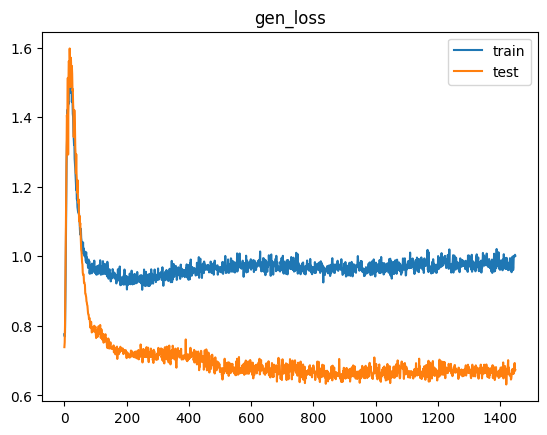

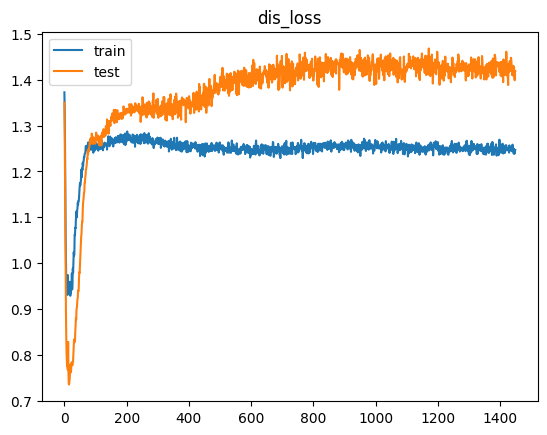

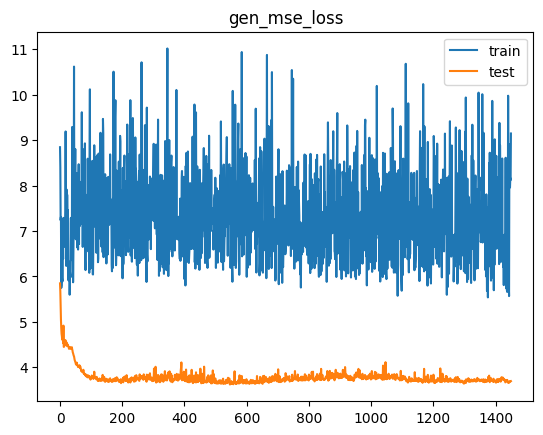

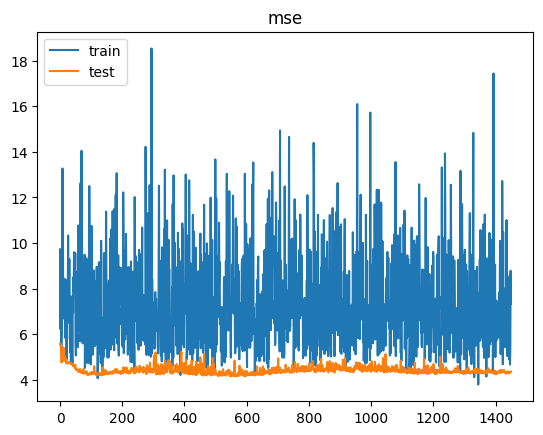

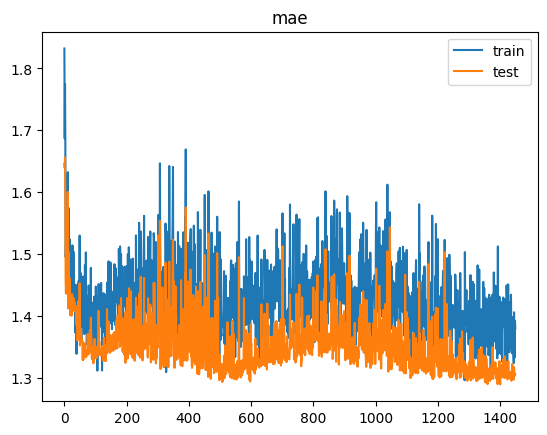

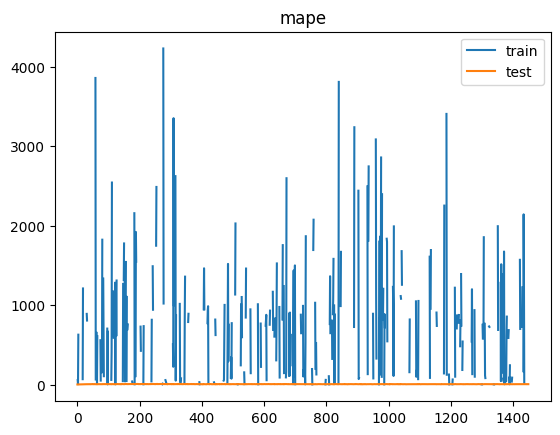

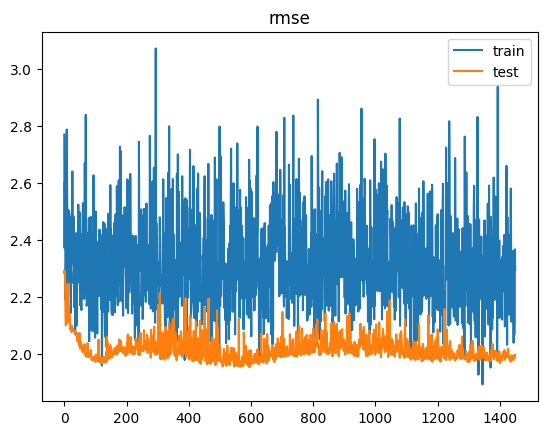

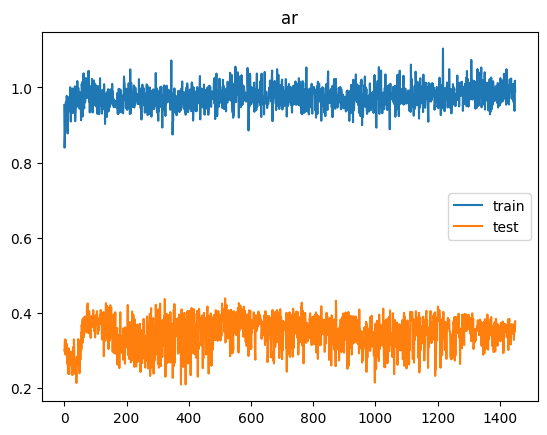

2/2 [==============================] - 0s 3ms/step


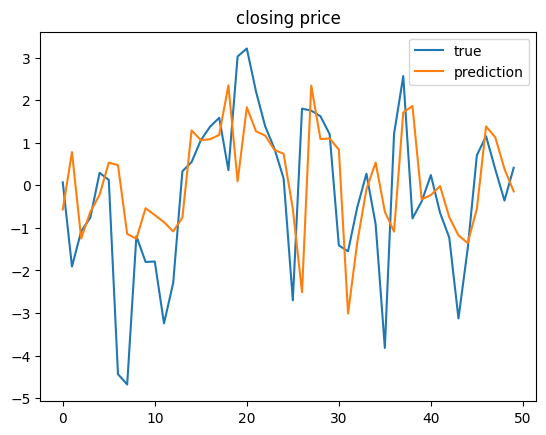

[MSE Baseline] train: 7.030080113202757  test: 4.16723565376744
Delta time with epochs = 1450: 0:19:10.206837
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 5, 10)             180       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_9 (

Time for epoch 53 is 0.8251488208770752 sec Generator Loss: 1.2345620393753052,  Discriminator_loss: 1.0647367238998413
Time for epoch 54 is 0.8151235580444336 sec Generator Loss: 1.2290797233581543,  Discriminator_loss: 1.0886015892028809
Time for epoch 55 is 0.7989323139190674 sec Generator Loss: 1.242272138595581,  Discriminator_loss: 1.0933327674865723
Time for epoch 56 is 0.8185961246490479 sec Generator Loss: 1.2165168523788452,  Discriminator_loss: 1.080657720565796
Time for epoch 57 is 0.81496262550354 sec Generator Loss: 1.1847448348999023,  Discriminator_loss: 1.1088049411773682
Time for epoch 58 is 0.8098387718200684 sec Generator Loss: 1.182763695716858,  Discriminator_loss: 1.1014149188995361
Time for epoch 59 is 0.8467268943786621 sec Generator Loss: 1.1565148830413818,  Discriminator_loss: 1.1297824382781982
Time for epoch 60 is 0.8301947116851807 sec Generator Loss: 1.1247594356536865,  Discriminator_loss: 1.138771891593933
Time for epoch 61 is 0.7948622703552246 sec Ge

Time for epoch 122 is 0.9323375225067139 sec Generator Loss: 0.9674875736236572,  Discriminator_loss: 1.264746069908142
Time for epoch 123 is 0.8913121223449707 sec Generator Loss: 0.9550269842147827,  Discriminator_loss: 1.2760066986083984
Time for epoch 124 is 1.0220978260040283 sec Generator Loss: 0.924717903137207,  Discriminator_loss: 1.277201771736145
Time for epoch 125 is 1.0066981315612793 sec Generator Loss: 0.940762460231781,  Discriminator_loss: 1.2681361436843872
Time for epoch 126 is 0.9867076873779297 sec Generator Loss: 0.948487401008606,  Discriminator_loss: 1.2679210901260376
Time for epoch 127 is 1.0923333168029785 sec Generator Loss: 0.9701477885246277,  Discriminator_loss: 1.2603174448013306
Time for epoch 128 is 0.9606854915618896 sec Generator Loss: 0.9663082957267761,  Discriminator_loss: 1.2713121175765991
Time for epoch 129 is 0.8142423629760742 sec Generator Loss: 0.9336904883384705,  Discriminator_loss: 1.2668063640594482
Time for epoch 130 is 0.7776932716369

Time for epoch 190 is 1.1849706172943115 sec Generator Loss: 0.9195800423622131,  Discriminator_loss: 1.2796833515167236
Time for epoch 191 is 1.1322948932647705 sec Generator Loss: 0.9110679626464844,  Discriminator_loss: 1.2868064641952515
Time for epoch 192 is 0.9978890419006348 sec Generator Loss: 0.9184348583221436,  Discriminator_loss: 1.2751179933547974
Time for epoch 193 is 0.9961094856262207 sec Generator Loss: 0.9107125997543335,  Discriminator_loss: 1.2828279733657837
Time for epoch 194 is 0.9350264072418213 sec Generator Loss: 0.9063345789909363,  Discriminator_loss: 1.2835198640823364
Time for epoch 195 is 0.8551862239837646 sec Generator Loss: 0.9211909770965576,  Discriminator_loss: 1.2745896577835083
Time for epoch 196 is 0.8532216548919678 sec Generator Loss: 0.9007099270820618,  Discriminator_loss: 1.2865153551101685
Time for epoch 197 is 0.8948378562927246 sec Generator Loss: 0.9255642890930176,  Discriminator_loss: 1.2706646919250488
Time for epoch 198 is 0.95487117

Time for epoch 258 is 0.8447492122650146 sec Generator Loss: 0.9244961738586426,  Discriminator_loss: 1.2816518545150757
Time for epoch 259 is 0.845548152923584 sec Generator Loss: 0.9086534380912781,  Discriminator_loss: 1.278944969177246
Time for epoch 260 is 0.8182308673858643 sec Generator Loss: 0.9189017415046692,  Discriminator_loss: 1.261360764503479
Time for epoch 261 is 0.8404059410095215 sec Generator Loss: 0.9216030240058899,  Discriminator_loss: 1.2750051021575928
Time for epoch 262 is 0.8358926773071289 sec Generator Loss: 0.9188055992126465,  Discriminator_loss: 1.2724554538726807
Time for epoch 263 is 0.818211555480957 sec Generator Loss: 0.9160304665565491,  Discriminator_loss: 1.2638405561447144
Time for epoch 264 is 0.8045344352722168 sec Generator Loss: 0.9143673777580261,  Discriminator_loss: 1.2672795057296753
Time for epoch 265 is 0.821514368057251 sec Generator Loss: 0.9277368783950806,  Discriminator_loss: 1.260973572731018
Time for epoch 266 is 0.81215190887451

Time for epoch 326 is 0.89451003074646 sec Generator Loss: 0.9339717626571655,  Discriminator_loss: 1.2689263820648193
Time for epoch 327 is 0.854149341583252 sec Generator Loss: 0.946645975112915,  Discriminator_loss: 1.2695021629333496
Time for epoch 328 is 0.895845890045166 sec Generator Loss: 0.9274058938026428,  Discriminator_loss: 1.2651705741882324
Time for epoch 329 is 0.8519291877746582 sec Generator Loss: 0.9445221424102783,  Discriminator_loss: 1.2708625793457031
Time for epoch 330 is 0.9033758640289307 sec Generator Loss: 0.9487484693527222,  Discriminator_loss: 1.2702929973602295
Time for epoch 331 is 0.8488643169403076 sec Generator Loss: 0.9305774569511414,  Discriminator_loss: 1.2723033428192139
Time for epoch 332 is 0.8945834636688232 sec Generator Loss: 0.9185789227485657,  Discriminator_loss: 1.2713924646377563
Time for epoch 333 is 0.8814527988433838 sec Generator Loss: 0.9192062616348267,  Discriminator_loss: 1.275003433227539
Time for epoch 334 is 0.87026834487915

Time for epoch 394 is 0.8543932437896729 sec Generator Loss: 0.9751446843147278,  Discriminator_loss: 1.2600897550582886
Time for epoch 395 is 0.8897714614868164 sec Generator Loss: 0.9520437717437744,  Discriminator_loss: 1.2675960063934326
Time for epoch 396 is 0.85642409324646 sec Generator Loss: 0.933064341545105,  Discriminator_loss: 1.261648178100586
Time for epoch 397 is 0.851271390914917 sec Generator Loss: 0.9379052519798279,  Discriminator_loss: 1.2662113904953003
Time for epoch 398 is 0.8755159378051758 sec Generator Loss: 0.9377565979957581,  Discriminator_loss: 1.2731539011001587
Time for epoch 399 is 0.8740994930267334 sec Generator Loss: 0.9223225116729736,  Discriminator_loss: 1.2644835710525513
Time for epoch 400 is 0.8630352020263672 sec Generator Loss: 0.9412948489189148,  Discriminator_loss: 1.2416731119155884
Time for epoch 401 is 0.9698131084442139 sec Generator Loss: 0.9674872159957886,  Discriminator_loss: 1.2555593252182007
Time for epoch 402 is 0.8087391853332

Time for epoch 462 is 0.8826682567596436 sec Generator Loss: 0.9565038681030273,  Discriminator_loss: 1.248255968093872
Time for epoch 463 is 0.8868730068206787 sec Generator Loss: 0.961954653263092,  Discriminator_loss: 1.2352609634399414
Time for epoch 464 is 0.8651869297027588 sec Generator Loss: 0.9331116080284119,  Discriminator_loss: 1.25899338722229
Time for epoch 465 is 1.0123839378356934 sec Generator Loss: 0.9601353406906128,  Discriminator_loss: 1.240495204925537
Time for epoch 466 is 1.0518689155578613 sec Generator Loss: 0.9544382095336914,  Discriminator_loss: 1.2603055238723755
Time for epoch 467 is 1.0067613124847412 sec Generator Loss: 0.9571061134338379,  Discriminator_loss: 1.2458959817886353
Time for epoch 468 is 0.9970090389251709 sec Generator Loss: 0.9475664496421814,  Discriminator_loss: 1.2448524236679077
Time for epoch 469 is 0.8674442768096924 sec Generator Loss: 0.968506932258606,  Discriminator_loss: 1.245615005493164
Time for epoch 470 is 0.816836595535278

Time for epoch 530 is 0.8378157615661621 sec Generator Loss: 0.9694827795028687,  Discriminator_loss: 1.253507137298584
Time for epoch 531 is 0.831268310546875 sec Generator Loss: 0.9722170233726501,  Discriminator_loss: 1.2393336296081543
Time for epoch 532 is 0.8246095180511475 sec Generator Loss: 0.9712631702423096,  Discriminator_loss: 1.2441314458847046
Time for epoch 533 is 0.8625752925872803 sec Generator Loss: 0.943413257598877,  Discriminator_loss: 1.2479075193405151
Time for epoch 534 is 0.8348262310028076 sec Generator Loss: 0.9619166851043701,  Discriminator_loss: 1.250482439994812
Time for epoch 535 is 0.822087287902832 sec Generator Loss: 0.953440248966217,  Discriminator_loss: 1.2501022815704346
Time for epoch 536 is 0.8570678234100342 sec Generator Loss: 0.9781583547592163,  Discriminator_loss: 1.238677740097046
Time for epoch 537 is 0.8177821636199951 sec Generator Loss: 0.9624014496803284,  Discriminator_loss: 1.246660828590393
Time for epoch 538 is 0.9556832313537598

Time for epoch 598 is 0.8396098613739014 sec Generator Loss: 0.9833356142044067,  Discriminator_loss: 1.2394487857818604
Time for epoch 599 is 0.8565890789031982 sec Generator Loss: 0.9842482805252075,  Discriminator_loss: 1.2379456758499146
Time for epoch 600 is 0.833245038986206 sec Generator Loss: 0.9729389548301697,  Discriminator_loss: 1.2408545017242432
Time for epoch 601 is 0.8922879695892334 sec Generator Loss: 0.9842386245727539,  Discriminator_loss: 1.2382729053497314
Time for epoch 602 is 1.1655867099761963 sec Generator Loss: 0.9711915254592896,  Discriminator_loss: 1.2437676191329956
Time for epoch 603 is 1.0172083377838135 sec Generator Loss: 0.9681780934333801,  Discriminator_loss: 1.2472954988479614
Time for epoch 604 is 1.0218892097473145 sec Generator Loss: 0.957748293876648,  Discriminator_loss: 1.2428064346313477
Time for epoch 605 is 0.898754358291626 sec Generator Loss: 0.9712980389595032,  Discriminator_loss: 1.241000771522522
Time for epoch 606 is 0.900763034820

Time for epoch 666 is 0.8871140480041504 sec Generator Loss: 0.9849478602409363,  Discriminator_loss: 1.2438220977783203
Time for epoch 667 is 0.8398075103759766 sec Generator Loss: 0.9717220067977905,  Discriminator_loss: 1.2364890575408936
Time for epoch 668 is 0.828840970993042 sec Generator Loss: 0.9635854363441467,  Discriminator_loss: 1.2479844093322754
Time for epoch 669 is 0.8729844093322754 sec Generator Loss: 0.9737475514411926,  Discriminator_loss: 1.2384411096572876
Time for epoch 670 is 0.8435070514678955 sec Generator Loss: 0.9753203392028809,  Discriminator_loss: 1.2514406442642212
Time for epoch 671 is 0.8690919876098633 sec Generator Loss: 0.9731613397598267,  Discriminator_loss: 1.2453835010528564
Time for epoch 672 is 0.8589622974395752 sec Generator Loss: 0.9555415511131287,  Discriminator_loss: 1.2454605102539062
Time for epoch 673 is 0.8414063453674316 sec Generator Loss: 0.9822655320167542,  Discriminator_loss: 1.2456380128860474
Time for epoch 674 is 0.851598739

Time for epoch 734 is 0.8548285961151123 sec Generator Loss: 0.9768170714378357,  Discriminator_loss: 1.2463947534561157
Time for epoch 735 is 0.8928024768829346 sec Generator Loss: 0.9904024600982666,  Discriminator_loss: 1.2423529624938965
Time for epoch 736 is 0.850226879119873 sec Generator Loss: 0.958980143070221,  Discriminator_loss: 1.2509058713912964
Time for epoch 737 is 0.871131181716919 sec Generator Loss: 0.9644636511802673,  Discriminator_loss: 1.2448188066482544
Time for epoch 738 is 0.8991069793701172 sec Generator Loss: 0.9616166353225708,  Discriminator_loss: 1.2526758909225464
Time for epoch 739 is 0.8624234199523926 sec Generator Loss: 0.9719297885894775,  Discriminator_loss: 1.2348591089248657
Time for epoch 740 is 0.8418002128601074 sec Generator Loss: 0.96772700548172,  Discriminator_loss: 1.2514081001281738
Time for epoch 741 is 0.8504533767700195 sec Generator Loss: 0.9713589549064636,  Discriminator_loss: 1.2407174110412598
Time for epoch 742 is 0.8494124412536

Time for epoch 803 is 1.0143320560455322 sec Generator Loss: 0.9637430310249329,  Discriminator_loss: 1.2542682886123657
Time for epoch 804 is 0.8593096733093262 sec Generator Loss: 0.991839587688446,  Discriminator_loss: 1.2345625162124634
Time for epoch 805 is 0.8578841686248779 sec Generator Loss: 0.9823960661888123,  Discriminator_loss: 1.2445971965789795
Time for epoch 806 is 0.8816065788269043 sec Generator Loss: 0.9720265865325928,  Discriminator_loss: 1.2532050609588623
Time for epoch 807 is 0.9592256546020508 sec Generator Loss: 0.9844515919685364,  Discriminator_loss: 1.2353148460388184
Time for epoch 808 is 0.8792929649353027 sec Generator Loss: 0.9617326259613037,  Discriminator_loss: 1.2544347047805786
Time for epoch 809 is 0.9433896541595459 sec Generator Loss: 0.9758051037788391,  Discriminator_loss: 1.2334492206573486
Time for epoch 810 is 0.8997673988342285 sec Generator Loss: 0.9772695302963257,  Discriminator_loss: 1.228772759437561
Time for epoch 811 is 0.8773801326

Time for epoch 872 is 0.9091598987579346 sec Generator Loss: 0.9717859625816345,  Discriminator_loss: 1.2457547187805176
Time for epoch 873 is 0.8973255157470703 sec Generator Loss: 1.0016762018203735,  Discriminator_loss: 1.246970772743225
Time for epoch 874 is 0.9156699180603027 sec Generator Loss: 0.9872998595237732,  Discriminator_loss: 1.2246445417404175
Time for epoch 875 is 0.8997926712036133 sec Generator Loss: 0.9841099381446838,  Discriminator_loss: 1.2515125274658203
Time for epoch 876 is 0.9431812763214111 sec Generator Loss: 0.9730085134506226,  Discriminator_loss: 1.2507562637329102
Time for epoch 877 is 0.8793044090270996 sec Generator Loss: 0.9755340218544006,  Discriminator_loss: 1.2495160102844238
Time for epoch 878 is 0.8998680114746094 sec Generator Loss: 0.9584818482398987,  Discriminator_loss: 1.2512953281402588
Time for epoch 879 is 0.9081902503967285 sec Generator Loss: 0.9785190224647522,  Discriminator_loss: 1.2449485063552856
Time for epoch 880 is 0.905166149

Time for epoch 940 is 0.9043169021606445 sec Generator Loss: 0.9464787840843201,  Discriminator_loss: 1.2563034296035767
Time for epoch 941 is 0.9095056056976318 sec Generator Loss: 1.0090163946151733,  Discriminator_loss: 1.2341996431350708
Time for epoch 942 is 0.9284262657165527 sec Generator Loss: 0.9563660621643066,  Discriminator_loss: 1.2535367012023926
Time for epoch 943 is 0.9652206897735596 sec Generator Loss: 0.9773584008216858,  Discriminator_loss: 1.2368336915969849
Time for epoch 944 is 1.0166876316070557 sec Generator Loss: 0.9671993851661682,  Discriminator_loss: 1.2466038465499878
Time for epoch 945 is 0.9823060035705566 sec Generator Loss: 0.9762868285179138,  Discriminator_loss: 1.2509523630142212
Time for epoch 946 is 0.977595329284668 sec Generator Loss: 0.9837748408317566,  Discriminator_loss: 1.2408617734909058
Time for epoch 947 is 0.9775722026824951 sec Generator Loss: 1.005750298500061,  Discriminator_loss: 1.238398551940918
Time for epoch 948 is 0.95606756210

Time for epoch 1008 is 0.9397592544555664 sec Generator Loss: 0.9748128652572632,  Discriminator_loss: 1.244675636291504
Time for epoch 1009 is 0.9352879524230957 sec Generator Loss: 0.9715988039970398,  Discriminator_loss: 1.2388031482696533
Time for epoch 1010 is 0.9704487323760986 sec Generator Loss: 0.9742228388786316,  Discriminator_loss: 1.243772268295288
Time for epoch 1011 is 0.9696531295776367 sec Generator Loss: 0.9608363509178162,  Discriminator_loss: 1.2504435777664185
Time for epoch 1012 is 0.992950439453125 sec Generator Loss: 0.9870965480804443,  Discriminator_loss: 1.2275102138519287
Time for epoch 1013 is 1.0623774528503418 sec Generator Loss: 0.9784345626831055,  Discriminator_loss: 1.2507033348083496
Time for epoch 1014 is 0.9590029716491699 sec Generator Loss: 0.966128408908844,  Discriminator_loss: 1.2410714626312256
Time for epoch 1015 is 0.9216742515563965 sec Generator Loss: 0.9812883138656616,  Discriminator_loss: 1.247635841369629
Time for epoch 1016 is 1.0306

Time for epoch 1076 is 0.9334194660186768 sec Generator Loss: 0.9784989953041077,  Discriminator_loss: 1.242403268814087
Time for epoch 1077 is 0.9086623191833496 sec Generator Loss: 0.9814518094062805,  Discriminator_loss: 1.240363359451294
Time for epoch 1078 is 0.8983283042907715 sec Generator Loss: 0.9858523607254028,  Discriminator_loss: 1.233612060546875
Time for epoch 1079 is 0.9087233543395996 sec Generator Loss: 0.987140953540802,  Discriminator_loss: 1.2408416271209717
Time for epoch 1080 is 0.921403169631958 sec Generator Loss: 0.9866066575050354,  Discriminator_loss: 1.222389578819275
Time for epoch 1081 is 0.901655912399292 sec Generator Loss: 0.973792552947998,  Discriminator_loss: 1.2455345392227173
Time for epoch 1082 is 0.9479434490203857 sec Generator Loss: 1.0014599561691284,  Discriminator_loss: 1.2422773838043213
Time for epoch 1083 is 0.944087028503418 sec Generator Loss: 0.9883970022201538,  Discriminator_loss: 1.228131651878357
Time for epoch 1084 is 1.056565761

Time for epoch 1144 is 0.9980442523956299 sec Generator Loss: 0.9904220700263977,  Discriminator_loss: 1.2282178401947021
Time for epoch 1145 is 1.1561400890350342 sec Generator Loss: 0.9947404861450195,  Discriminator_loss: 1.2398625612258911
Time for epoch 1146 is 1.0152299404144287 sec Generator Loss: 1.0040432214736938,  Discriminator_loss: 1.2281829118728638
Time for epoch 1147 is 1.0289647579193115 sec Generator Loss: 0.9997934699058533,  Discriminator_loss: 1.2247138023376465
Time for epoch 1148 is 0.9275777339935303 sec Generator Loss: 0.960262656211853,  Discriminator_loss: 1.2483904361724854
Time for epoch 1149 is 0.9214816093444824 sec Generator Loss: 1.0094014406204224,  Discriminator_loss: 1.2347352504730225
Time for epoch 1150 is 0.97857666015625 sec Generator Loss: 1.004894733428955,  Discriminator_loss: 1.243543267250061
Time for epoch 1151 is 0.9414870738983154 sec Generator Loss: 1.0012423992156982,  Discriminator_loss: 1.2475470304489136
Time for epoch 1152 is 0.9363

Time for epoch 1212 is 0.9225225448608398 sec Generator Loss: 0.9802680611610413,  Discriminator_loss: 1.2388252019882202
Time for epoch 1213 is 0.9058282375335693 sec Generator Loss: 1.0065199136734009,  Discriminator_loss: 1.2266499996185303
Time for epoch 1214 is 1.0500798225402832 sec Generator Loss: 0.9970561265945435,  Discriminator_loss: 1.241716742515564
Time for epoch 1215 is 1.0044679641723633 sec Generator Loss: 1.011061668395996,  Discriminator_loss: 1.237302541732788
Time for epoch 1216 is 1.0781464576721191 sec Generator Loss: 1.0194964408874512,  Discriminator_loss: 1.2230771780014038
Time for epoch 1217 is 1.0228633880615234 sec Generator Loss: 0.9853163957595825,  Discriminator_loss: 1.2393825054168701
Time for epoch 1218 is 0.9815640449523926 sec Generator Loss: 1.0147970914840698,  Discriminator_loss: 1.230922818183899
Time for epoch 1219 is 0.957291841506958 sec Generator Loss: 0.9958568215370178,  Discriminator_loss: 1.235190510749817
Time for epoch 1220 is 0.89624

Time for epoch 1280 is 0.8967628479003906 sec Generator Loss: 0.987359881401062,  Discriminator_loss: 1.2439481019973755
Time for epoch 1281 is 0.900223970413208 sec Generator Loss: 0.9803192019462585,  Discriminator_loss: 1.2370376586914062
Time for epoch 1282 is 0.8980154991149902 sec Generator Loss: 0.9756394624710083,  Discriminator_loss: 1.2370790243148804
Time for epoch 1283 is 0.9025392532348633 sec Generator Loss: 0.9943455457687378,  Discriminator_loss: 1.2388973236083984
Time for epoch 1284 is 0.9452250003814697 sec Generator Loss: 0.9857545495033264,  Discriminator_loss: 1.2379528284072876
Time for epoch 1285 is 0.9094419479370117 sec Generator Loss: 0.9953973889350891,  Discriminator_loss: 1.23881995677948
Time for epoch 1286 is 0.88088059425354 sec Generator Loss: 0.9908846616744995,  Discriminator_loss: 1.2293161153793335
Time for epoch 1287 is 0.8859643936157227 sec Generator Loss: 0.9944321513175964,  Discriminator_loss: 1.2331595420837402
Time for epoch 1288 is 0.93088

Time for epoch 1348 is 0.9189662933349609 sec Generator Loss: 0.9809862971305847,  Discriminator_loss: 1.2422317266464233
Time for epoch 1349 is 0.91703200340271 sec Generator Loss: 0.9791451096534729,  Discriminator_loss: 1.2373051643371582
Time for epoch 1350 is 0.9308710098266602 sec Generator Loss: 0.9962316155433655,  Discriminator_loss: 1.233471155166626
Time for epoch 1351 is 0.9992492198944092 sec Generator Loss: 1.002118706703186,  Discriminator_loss: 1.2255101203918457
Time for epoch 1352 is 1.005152940750122 sec Generator Loss: 0.975974440574646,  Discriminator_loss: 1.2398334741592407
Time for epoch 1353 is 0.9261760711669922 sec Generator Loss: 0.9978612661361694,  Discriminator_loss: 1.239669680595398
Time for epoch 1354 is 0.9480957984924316 sec Generator Loss: 0.9792234301567078,  Discriminator_loss: 1.2423957586288452
Time for epoch 1355 is 0.9177370071411133 sec Generator Loss: 0.9746835827827454,  Discriminator_loss: 1.2446339130401611
Time for epoch 1356 is 0.975692

Time for epoch 1416 is 0.9274797439575195 sec Generator Loss: 0.9589762091636658,  Discriminator_loss: 1.240509271621704
Time for epoch 1417 is 0.930189847946167 sec Generator Loss: 0.9794453382492065,  Discriminator_loss: 1.2241570949554443
Time for epoch 1418 is 0.9260780811309814 sec Generator Loss: 0.977677583694458,  Discriminator_loss: 1.2404358386993408
Time for epoch 1419 is 0.9505236148834229 sec Generator Loss: 1.0073835849761963,  Discriminator_loss: 1.232527494430542
Time for epoch 1420 is 0.968937873840332 sec Generator Loss: 0.9778512716293335,  Discriminator_loss: 1.2561287879943848
Time for epoch 1421 is 0.9724123477935791 sec Generator Loss: 1.012654185295105,  Discriminator_loss: 1.2509047985076904
Time for epoch 1422 is 0.9360175132751465 sec Generator Loss: 0.9768954515457153,  Discriminator_loss: 1.227925181388855
Time for epoch 1423 is 0.9320669174194336 sec Generator Loss: 0.989200234413147,  Discriminator_loss: 1.2421956062316895
Time for epoch 1424 is 0.9491484

Time for epoch 1484 is 1.1201691627502441 sec Generator Loss: 0.993829071521759,  Discriminator_loss: 1.2286455631256104
Time for epoch 1485 is 0.9729084968566895 sec Generator Loss: 0.9937277436256409,  Discriminator_loss: 1.2392388582229614
Time for epoch 1486 is 0.9636437892913818 sec Generator Loss: 0.9862914085388184,  Discriminator_loss: 1.2350132465362549
Time for epoch 1487 is 0.975029706954956 sec Generator Loss: 0.9914135932922363,  Discriminator_loss: 1.246810793876648
Time for epoch 1488 is 0.926823616027832 sec Generator Loss: 1.0028232336044312,  Discriminator_loss: 1.2360639572143555
Time for epoch 1489 is 0.9737775325775146 sec Generator Loss: 0.9998028874397278,  Discriminator_loss: 1.237946629524231
Time for epoch 1490 is 0.9578866958618164 sec Generator Loss: 0.9774383306503296,  Discriminator_loss: 1.2324765920639038
Time for epoch 1491 is 1.035541296005249 sec Generator Loss: 0.9967420697212219,  Discriminator_loss: 1.2309308052062988
Time for epoch 1492 is 1.11114

Time for epoch 1552 is 1.2639853954315186 sec Generator Loss: 0.9671649932861328,  Discriminator_loss: 1.2472957372665405
Time for epoch 1553 is 1.0847911834716797 sec Generator Loss: 0.9939044713973999,  Discriminator_loss: 1.2382895946502686
Time for epoch 1554 is 1.0104506015777588 sec Generator Loss: 1.0007344484329224,  Discriminator_loss: 1.2280666828155518
Time for epoch 1555 is 0.9679932594299316 sec Generator Loss: 1.004111409187317,  Discriminator_loss: 1.2354004383087158
Time for epoch 1556 is 0.9645140171051025 sec Generator Loss: 0.9848857522010803,  Discriminator_loss: 1.2348884344100952
Time for epoch 1557 is 0.9943768978118896 sec Generator Loss: 0.9908269047737122,  Discriminator_loss: 1.2405519485473633
Time for epoch 1558 is 0.9464001655578613 sec Generator Loss: 0.9870214462280273,  Discriminator_loss: 1.235077977180481
Time for epoch 1559 is 0.9512729644775391 sec Generator Loss: 1.0098730325698853,  Discriminator_loss: 1.241709589958191
Time for epoch 1560 is 0.98

Time for epoch 1620 is 0.9410686492919922 sec Generator Loss: 0.9818422794342041,  Discriminator_loss: 1.2503750324249268
Time for epoch 1621 is 0.9474806785583496 sec Generator Loss: 0.9801202416419983,  Discriminator_loss: 1.231548547744751
Time for epoch 1622 is 0.9380640983581543 sec Generator Loss: 0.9987491369247437,  Discriminator_loss: 1.2351917028427124
Time for epoch 1623 is 0.9327855110168457 sec Generator Loss: 0.9825819730758667,  Discriminator_loss: 1.2506486177444458
Time for epoch 1624 is 0.9409375190734863 sec Generator Loss: 0.981311023235321,  Discriminator_loss: 1.2447209358215332
Time for epoch 1625 is 0.9009363651275635 sec Generator Loss: 0.9767364859580994,  Discriminator_loss: 1.2454864978790283
Time for epoch 1626 is 0.9109034538269043 sec Generator Loss: 0.9969927072525024,  Discriminator_loss: 1.2447504997253418
Time for epoch 1627 is 0.9395694732666016 sec Generator Loss: 0.9841593503952026,  Discriminator_loss: 1.2524242401123047
Time for epoch 1628 is 0.9

Time for epoch 1688 is 0.9776320457458496 sec Generator Loss: 1.0065488815307617,  Discriminator_loss: 1.2231621742248535
Time for epoch 1689 is 0.9923689365386963 sec Generator Loss: 0.9766739010810852,  Discriminator_loss: 1.2382383346557617
Time for epoch 1690 is 1.019629955291748 sec Generator Loss: 0.9819126725196838,  Discriminator_loss: 1.2402726411819458
Time for epoch 1691 is 1.0383045673370361 sec Generator Loss: 0.9791615009307861,  Discriminator_loss: 1.2410709857940674
Time for epoch 1692 is 1.0764591693878174 sec Generator Loss: 0.9955170750617981,  Discriminator_loss: 1.243291974067688
Time for epoch 1693 is 1.0054755210876465 sec Generator Loss: 0.9849245548248291,  Discriminator_loss: 1.2380306720733643
Time for epoch 1694 is 1.0884480476379395 sec Generator Loss: 1.0030789375305176,  Discriminator_loss: 1.236974835395813
Time for epoch 1695 is 1.2566032409667969 sec Generator Loss: 0.9965991973876953,  Discriminator_loss: 1.2380239963531494
Time for epoch 1696 is 1.29

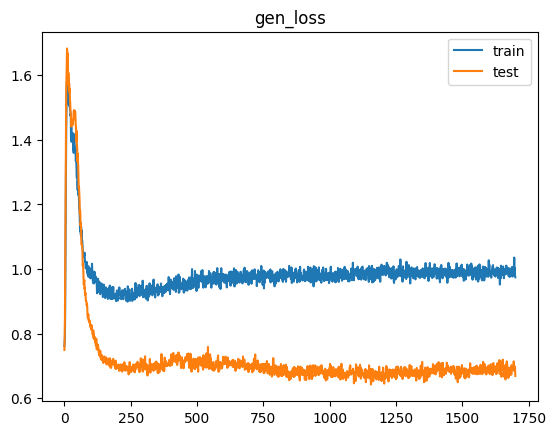

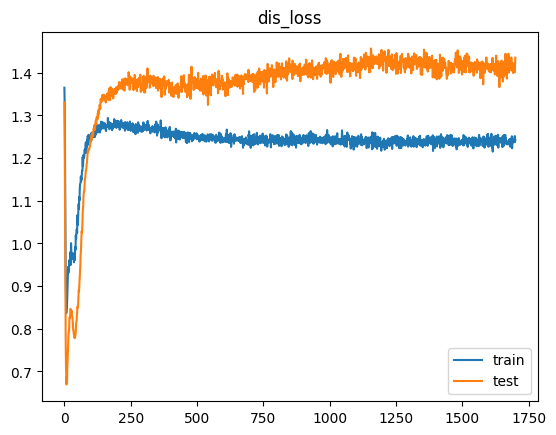

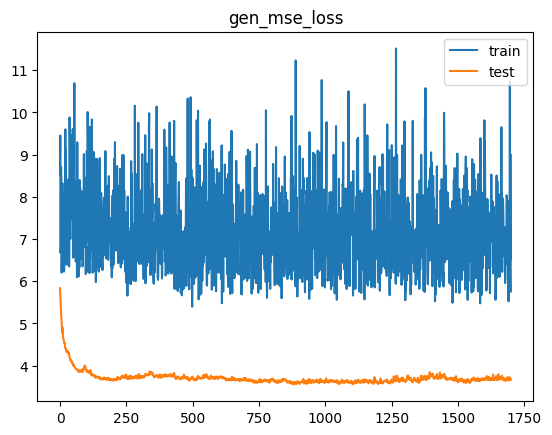

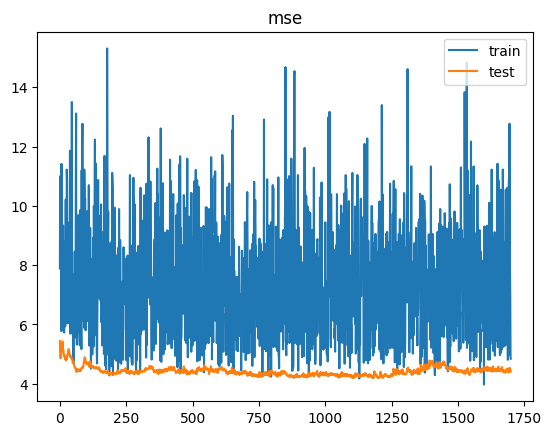

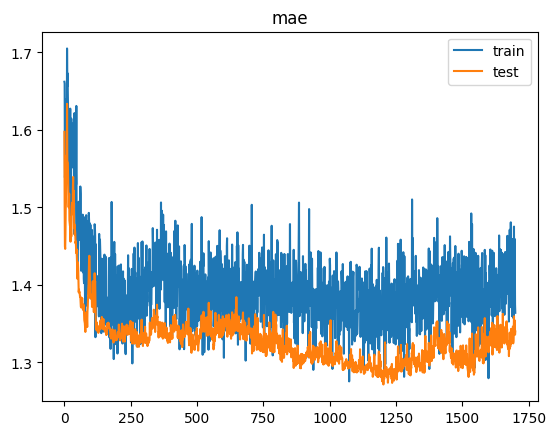

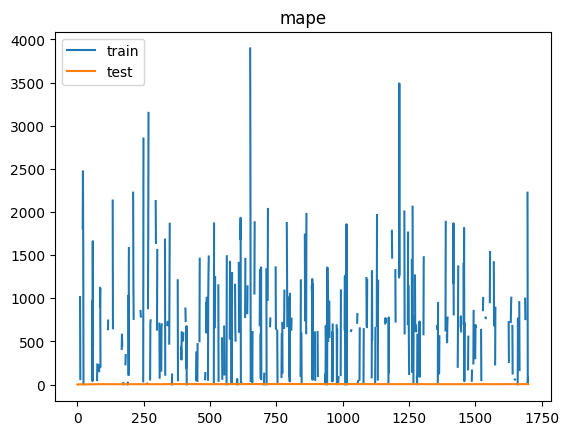

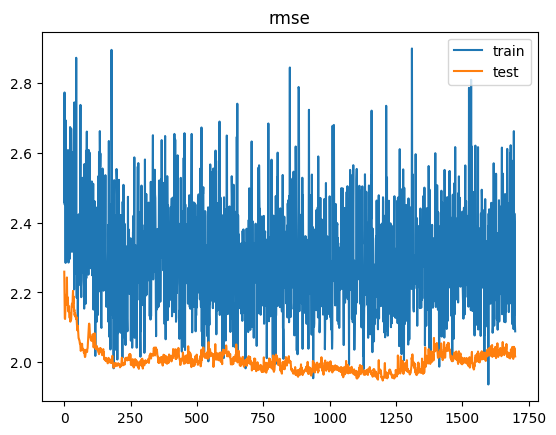

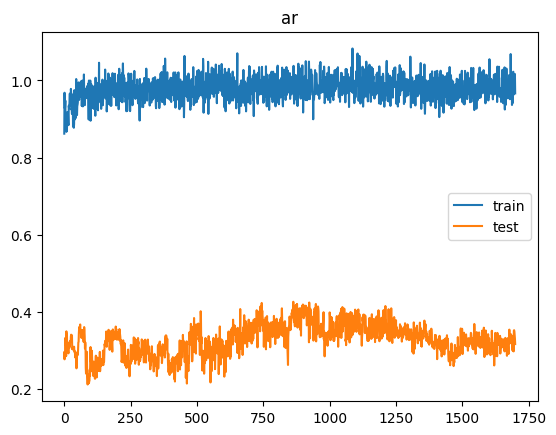

2/2 [==============================] - 0s 4ms/step


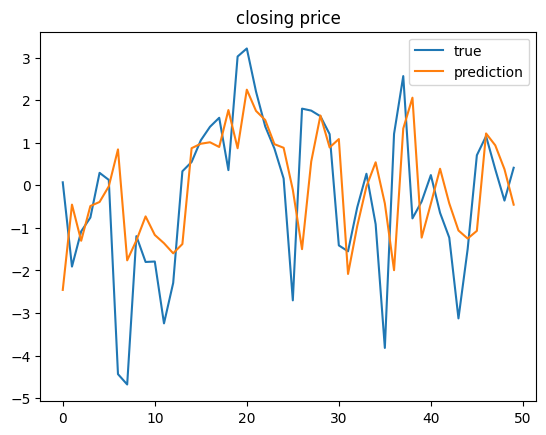

[MSE Baseline] train: 8.740277791570696  test: 4.16723565376744
Delta time with epochs = 1700: 0:27:09.939734
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 5, 10)             180       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 simple_rnn_11 

Time for epoch 52 is 0.9574296474456787 sec Generator Loss: 1.009394884109497,  Discriminator_loss: 1.2132492065429688
Time for epoch 53 is 0.9907629489898682 sec Generator Loss: 1.005431890487671,  Discriminator_loss: 1.2162882089614868
Time for epoch 54 is 0.9500958919525146 sec Generator Loss: 1.0055372714996338,  Discriminator_loss: 1.219474196434021
Time for epoch 55 is 0.9822356700897217 sec Generator Loss: 0.9807860851287842,  Discriminator_loss: 1.2296473979949951
Time for epoch 56 is 0.9867870807647705 sec Generator Loss: 1.0232435464859009,  Discriminator_loss: 1.2199712991714478
Time for epoch 57 is 0.9643270969390869 sec Generator Loss: 1.0086960792541504,  Discriminator_loss: 1.222298502922058
Time for epoch 58 is 0.9762539863586426 sec Generator Loss: 0.9806113839149475,  Discriminator_loss: 1.230918526649475
Time for epoch 59 is 0.9579658508300781 sec Generator Loss: 1.003444790840149,  Discriminator_loss: 1.2242507934570312
Time for epoch 60 is 1.0112712383270264 sec Ge

Time for epoch 121 is 0.9399700164794922 sec Generator Loss: 0.9091854691505432,  Discriminator_loss: 1.2832027673721313
Time for epoch 122 is 0.9475512504577637 sec Generator Loss: 0.8979849219322205,  Discriminator_loss: 1.291433572769165
Time for epoch 123 is 0.9170248508453369 sec Generator Loss: 0.8987616300582886,  Discriminator_loss: 1.2820405960083008
Time for epoch 124 is 0.9472677707672119 sec Generator Loss: 0.9046732187271118,  Discriminator_loss: 1.2912006378173828
Time for epoch 125 is 0.9433834552764893 sec Generator Loss: 0.896705687046051,  Discriminator_loss: 1.2814161777496338
Time for epoch 126 is 1.0002055168151855 sec Generator Loss: 0.9049645662307739,  Discriminator_loss: 1.2873437404632568
Time for epoch 127 is 0.94478440284729 sec Generator Loss: 0.9088238477706909,  Discriminator_loss: 1.2861088514328003
Time for epoch 128 is 0.9589195251464844 sec Generator Loss: 0.905242383480072,  Discriminator_loss: 1.285780668258667
Time for epoch 129 is 0.98104691505432

Time for epoch 190 is 1.215510606765747 sec Generator Loss: 0.8915594220161438,  Discriminator_loss: 1.2925740480422974
Time for epoch 191 is 1.0610265731811523 sec Generator Loss: 0.8999634981155396,  Discriminator_loss: 1.2919529676437378
Time for epoch 192 is 1.0313520431518555 sec Generator Loss: 0.9124045968055725,  Discriminator_loss: 1.2930423021316528
Time for epoch 193 is 1.0033035278320312 sec Generator Loss: 0.8957506418228149,  Discriminator_loss: 1.2957946062088013
Time for epoch 194 is 0.9521288871765137 sec Generator Loss: 0.9042401313781738,  Discriminator_loss: 1.2870784997940063
Time for epoch 195 is 1.0063841342926025 sec Generator Loss: 0.9185689091682434,  Discriminator_loss: 1.2797452211380005
Time for epoch 196 is 1.0238144397735596 sec Generator Loss: 0.8957076668739319,  Discriminator_loss: 1.287308692932129
Time for epoch 197 is 1.0648319721221924 sec Generator Loss: 0.906822144985199,  Discriminator_loss: 1.2823458909988403
Time for epoch 198 is 1.04200267791

Time for epoch 258 is 1.074000597000122 sec Generator Loss: 0.907655656337738,  Discriminator_loss: 1.2875877618789673
Time for epoch 259 is 1.1215429306030273 sec Generator Loss: 0.9179338216781616,  Discriminator_loss: 1.2665961980819702
Time for epoch 260 is 1.0829415321350098 sec Generator Loss: 0.9124997854232788,  Discriminator_loss: 1.2844698429107666
Time for epoch 261 is 0.9620914459228516 sec Generator Loss: 0.9123528599739075,  Discriminator_loss: 1.2820985317230225
Time for epoch 262 is 0.9349627494812012 sec Generator Loss: 0.9289370179176331,  Discriminator_loss: 1.2744884490966797
Time for epoch 263 is 0.9818253517150879 sec Generator Loss: 0.9005637168884277,  Discriminator_loss: 1.2741692066192627
Time for epoch 264 is 0.9840991497039795 sec Generator Loss: 0.9162960052490234,  Discriminator_loss: 1.296805500984192
Time for epoch 265 is 0.9864177703857422 sec Generator Loss: 0.9089809060096741,  Discriminator_loss: 1.2709895372390747
Time for epoch 266 is 0.97107052803

Time for epoch 326 is 0.8986659049987793 sec Generator Loss: 0.9277616143226624,  Discriminator_loss: 1.2789376974105835
Time for epoch 327 is 0.8212804794311523 sec Generator Loss: 0.9212590456008911,  Discriminator_loss: 1.277509331703186
Time for epoch 328 is 0.8554050922393799 sec Generator Loss: 0.918987512588501,  Discriminator_loss: 1.2736719846725464
Time for epoch 329 is 0.8392508029937744 sec Generator Loss: 0.9141975045204163,  Discriminator_loss: 1.2685760259628296
Time for epoch 330 is 0.8537948131561279 sec Generator Loss: 0.9261747002601624,  Discriminator_loss: 1.2699235677719116
Time for epoch 331 is 0.876554012298584 sec Generator Loss: 0.9333085417747498,  Discriminator_loss: 1.2691351175308228
Time for epoch 332 is 0.936837911605835 sec Generator Loss: 0.9175184965133667,  Discriminator_loss: 1.2628413438796997
Time for epoch 333 is 1.0902419090270996 sec Generator Loss: 0.9499483108520508,  Discriminator_loss: 1.2673808336257935
Time for epoch 334 is 0.909963607788

Time for epoch 395 is 0.9512748718261719 sec Generator Loss: 0.9555785059928894,  Discriminator_loss: 1.2633585929870605
Time for epoch 396 is 0.8954877853393555 sec Generator Loss: 0.9228679537773132,  Discriminator_loss: 1.2683802843093872
Time for epoch 397 is 0.8816494941711426 sec Generator Loss: 0.9224099516868591,  Discriminator_loss: 1.2561602592468262
Time for epoch 398 is 0.9091744422912598 sec Generator Loss: 0.9506903886795044,  Discriminator_loss: 1.252001404762268
Time for epoch 399 is 0.9726905822753906 sec Generator Loss: 0.9415531158447266,  Discriminator_loss: 1.2627348899841309
Time for epoch 400 is 0.9555184841156006 sec Generator Loss: 0.915580689907074,  Discriminator_loss: 1.2764438390731812
Time for epoch 401 is 0.8721194267272949 sec Generator Loss: 0.9536200761795044,  Discriminator_loss: 1.2696723937988281
Time for epoch 402 is 0.8756058216094971 sec Generator Loss: 0.9330176711082458,  Discriminator_loss: 1.2669380903244019
Time for epoch 403 is 0.9159874916

Time for epoch 464 is 1.5343787670135498 sec Generator Loss: 0.9475932717323303,  Discriminator_loss: 1.2547920942306519
Time for epoch 465 is 0.8988821506500244 sec Generator Loss: 0.9485052227973938,  Discriminator_loss: 1.2661716938018799
Time for epoch 466 is 1.0361857414245605 sec Generator Loss: 0.9241127371788025,  Discriminator_loss: 1.2782458066940308
Time for epoch 467 is 0.9224317073822021 sec Generator Loss: 0.9260963797569275,  Discriminator_loss: 1.2646995782852173
Time for epoch 468 is 0.8707051277160645 sec Generator Loss: 0.9079759120941162,  Discriminator_loss: 1.271342158317566
Time for epoch 469 is 0.9081602096557617 sec Generator Loss: 0.9235446453094482,  Discriminator_loss: 1.2733213901519775
Time for epoch 470 is 0.8732478618621826 sec Generator Loss: 0.9471765756607056,  Discriminator_loss: 1.2650386095046997
Time for epoch 471 is 0.8700745105743408 sec Generator Loss: 0.9500553607940674,  Discriminator_loss: 1.2614920139312744
Time for epoch 472 is 0.893752574

Time for epoch 532 is 0.958981990814209 sec Generator Loss: 0.9390238523483276,  Discriminator_loss: 1.2583427429199219
Time for epoch 533 is 1.0253303050994873 sec Generator Loss: 0.9509534239768982,  Discriminator_loss: 1.254381537437439
Time for epoch 534 is 1.004335641860962 sec Generator Loss: 0.9321138858795166,  Discriminator_loss: 1.262855887413025
Time for epoch 535 is 0.9724676609039307 sec Generator Loss: 0.9320987462997437,  Discriminator_loss: 1.2662206888198853
Time for epoch 536 is 0.9837229251861572 sec Generator Loss: 0.9284679293632507,  Discriminator_loss: 1.2717652320861816
Time for epoch 537 is 0.9826006889343262 sec Generator Loss: 0.9582384824752808,  Discriminator_loss: 1.256044626235962
Time for epoch 538 is 0.9737465381622314 sec Generator Loss: 0.9332104325294495,  Discriminator_loss: 1.2614953517913818
Time for epoch 539 is 1.0214028358459473 sec Generator Loss: 0.9467025995254517,  Discriminator_loss: 1.2587757110595703
Time for epoch 540 is 1.0241448879241

Time for epoch 601 is 0.9321761131286621 sec Generator Loss: 0.9487549066543579,  Discriminator_loss: 1.2574810981750488
Time for epoch 602 is 0.9675450325012207 sec Generator Loss: 0.9432181715965271,  Discriminator_loss: 1.2599016427993774
Time for epoch 603 is 0.9299931526184082 sec Generator Loss: 0.9355748891830444,  Discriminator_loss: 1.2662172317504883
Time for epoch 604 is 0.8792374134063721 sec Generator Loss: 0.9378372430801392,  Discriminator_loss: 1.2548052072525024
Time for epoch 605 is 0.92848801612854 sec Generator Loss: 0.9490629434585571,  Discriminator_loss: 1.2676790952682495
Time for epoch 606 is 0.9280056953430176 sec Generator Loss: 0.9569292068481445,  Discriminator_loss: 1.2437902688980103
Time for epoch 607 is 0.922541618347168 sec Generator Loss: 0.9539231657981873,  Discriminator_loss: 1.267932653427124
Time for epoch 608 is 0.898385763168335 sec Generator Loss: 0.9499019384384155,  Discriminator_loss: 1.255277395248413
Time for epoch 609 is 0.87825322151184

Time for epoch 670 is 1.1601579189300537 sec Generator Loss: 0.9407515525817871,  Discriminator_loss: 1.2572938203811646
Time for epoch 671 is 1.2179746627807617 sec Generator Loss: 0.9526280760765076,  Discriminator_loss: 1.2590492963790894
Time for epoch 672 is 1.3500173091888428 sec Generator Loss: 0.9346978664398193,  Discriminator_loss: 1.2608901262283325
Time for epoch 673 is 1.0906670093536377 sec Generator Loss: 0.9468979835510254,  Discriminator_loss: 1.2601810693740845
Time for epoch 674 is 1.0148260593414307 sec Generator Loss: 0.9443163275718689,  Discriminator_loss: 1.2493611574172974
Time for epoch 675 is 1.1997270584106445 sec Generator Loss: 0.9304513931274414,  Discriminator_loss: 1.261760950088501
Time for epoch 676 is 1.3739655017852783 sec Generator Loss: 0.9553036689758301,  Discriminator_loss: 1.252882480621338
Time for epoch 677 is 1.1250717639923096 sec Generator Loss: 0.9281720519065857,  Discriminator_loss: 1.2732621431350708
Time for epoch 678 is 1.1461453437

Time for epoch 739 is 1.002746820449829 sec Generator Loss: 0.9461402893066406,  Discriminator_loss: 1.2635067701339722
Time for epoch 740 is 1.0407061576843262 sec Generator Loss: 0.9334982633590698,  Discriminator_loss: 1.2655518054962158
Time for epoch 741 is 1.0097298622131348 sec Generator Loss: 0.9704254269599915,  Discriminator_loss: 1.2461535930633545
Time for epoch 742 is 1.0147619247436523 sec Generator Loss: 0.9503365755081177,  Discriminator_loss: 1.2575526237487793
Time for epoch 743 is 1.0158977508544922 sec Generator Loss: 0.960504412651062,  Discriminator_loss: 1.2610270977020264
Time for epoch 744 is 0.9028079509735107 sec Generator Loss: 0.9478610157966614,  Discriminator_loss: 1.2629389762878418
Time for epoch 745 is 0.893667459487915 sec Generator Loss: 0.9440866708755493,  Discriminator_loss: 1.2519713640213013
Time for epoch 746 is 0.8986573219299316 sec Generator Loss: 0.931074857711792,  Discriminator_loss: 1.258996605873108
Time for epoch 747 is 0.9217894077301

Time for epoch 807 is 1.1865861415863037 sec Generator Loss: 0.9859527349472046,  Discriminator_loss: 1.2424224615097046
Time for epoch 808 is 1.2416086196899414 sec Generator Loss: 0.951718807220459,  Discriminator_loss: 1.2480562925338745
Time for epoch 809 is 1.1889638900756836 sec Generator Loss: 0.9478260278701782,  Discriminator_loss: 1.2568998336791992
Time for epoch 810 is 1.0296852588653564 sec Generator Loss: 0.939440131187439,  Discriminator_loss: 1.2527832984924316
Time for epoch 811 is 1.2328665256500244 sec Generator Loss: 0.9380612373352051,  Discriminator_loss: 1.2646229267120361
Time for epoch 812 is 1.2967205047607422 sec Generator Loss: 0.9418576955795288,  Discriminator_loss: 1.2610963582992554
Time for epoch 813 is 1.3517701625823975 sec Generator Loss: 0.960219144821167,  Discriminator_loss: 1.2567877769470215
Time for epoch 814 is 1.3716845512390137 sec Generator Loss: 0.9669782519340515,  Discriminator_loss: 1.2593837976455688
Time for epoch 815 is 1.36951017379

Time for epoch 876 is 0.9904615879058838 sec Generator Loss: 0.9547878503799438,  Discriminator_loss: 1.2528389692306519
Time for epoch 877 is 1.0022108554840088 sec Generator Loss: 0.9611361622810364,  Discriminator_loss: 1.2535706758499146
Time for epoch 878 is 1.007582426071167 sec Generator Loss: 0.9573644995689392,  Discriminator_loss: 1.258131980895996
Time for epoch 879 is 0.9792220592498779 sec Generator Loss: 0.9422211647033691,  Discriminator_loss: 1.2610132694244385
Time for epoch 880 is 0.9858598709106445 sec Generator Loss: 0.944274365901947,  Discriminator_loss: 1.2503122091293335
Time for epoch 881 is 0.9883894920349121 sec Generator Loss: 0.9556576013565063,  Discriminator_loss: 1.245971441268921
Time for epoch 882 is 0.9829645156860352 sec Generator Loss: 0.9693846702575684,  Discriminator_loss: 1.257680058479309
Time for epoch 883 is 1.0583488941192627 sec Generator Loss: 0.9621293544769287,  Discriminator_loss: 1.2476800680160522
Time for epoch 884 is 1.0205361843109

Time for epoch 945 is 1.143420934677124 sec Generator Loss: 0.955318808555603,  Discriminator_loss: 1.263938069343567
Time for epoch 946 is 1.177100419998169 sec Generator Loss: 0.9438384771347046,  Discriminator_loss: 1.2508776187896729
Time for epoch 947 is 1.0938467979431152 sec Generator Loss: 0.9581359028816223,  Discriminator_loss: 1.2514203786849976
Time for epoch 948 is 1.0579934120178223 sec Generator Loss: 0.9715367555618286,  Discriminator_loss: 1.2483203411102295
Time for epoch 949 is 1.0691909790039062 sec Generator Loss: 0.9573301076889038,  Discriminator_loss: 1.2462066411972046
Time for epoch 950 is 1.0690903663635254 sec Generator Loss: 0.9567947387695312,  Discriminator_loss: 1.2508611679077148
Time for epoch 951 is 1.0989940166473389 sec Generator Loss: 0.9493471384048462,  Discriminator_loss: 1.2557263374328613
Time for epoch 952 is 1.1209266185760498 sec Generator Loss: 0.9455525279045105,  Discriminator_loss: 1.246243953704834
Time for epoch 953 is 1.0292749404907

Time for epoch 1013 is 1.085458517074585 sec Generator Loss: 0.9790335893630981,  Discriminator_loss: 1.2444943189620972
Time for epoch 1014 is 1.157973051071167 sec Generator Loss: 0.9583286643028259,  Discriminator_loss: 1.2377440929412842
Time for epoch 1015 is 1.0794026851654053 sec Generator Loss: 0.9606409072875977,  Discriminator_loss: 1.250464916229248
Time for epoch 1016 is 1.1053078174591064 sec Generator Loss: 0.9706270098686218,  Discriminator_loss: 1.2472459077835083
Time for epoch 1017 is 1.105794906616211 sec Generator Loss: 0.9555646777153015,  Discriminator_loss: 1.2534650564193726
Time for epoch 1018 is 1.0742385387420654 sec Generator Loss: 0.9514942765235901,  Discriminator_loss: 1.2553532123565674
Time for epoch 1019 is 1.0933713912963867 sec Generator Loss: 0.9673915505409241,  Discriminator_loss: 1.2461540699005127
Time for epoch 1020 is 1.130342960357666 sec Generator Loss: 0.9486607909202576,  Discriminator_loss: 1.26394522190094
Time for epoch 1021 is 1.151427

Time for epoch 1081 is 1.117163896560669 sec Generator Loss: 0.964286208152771,  Discriminator_loss: 1.2594257593154907
Time for epoch 1082 is 1.0606489181518555 sec Generator Loss: 0.9606482982635498,  Discriminator_loss: 1.2510944604873657
Time for epoch 1083 is 1.013031005859375 sec Generator Loss: 0.9555307626724243,  Discriminator_loss: 1.2465792894363403
Time for epoch 1084 is 1.0810909271240234 sec Generator Loss: 0.9485482573509216,  Discriminator_loss: 1.2524223327636719
Time for epoch 1085 is 1.0524070262908936 sec Generator Loss: 0.9566026926040649,  Discriminator_loss: 1.2565135955810547
Time for epoch 1086 is 1.1876587867736816 sec Generator Loss: 0.9855796694755554,  Discriminator_loss: 1.2344460487365723
Time for epoch 1087 is 1.178739309310913 sec Generator Loss: 0.9627310037612915,  Discriminator_loss: 1.2384916543960571
Time for epoch 1088 is 1.1649303436279297 sec Generator Loss: 0.9710553884506226,  Discriminator_loss: 1.2555866241455078
Time for epoch 1089 is 1.332

Time for epoch 1149 is 1.4464635848999023 sec Generator Loss: 0.9684791564941406,  Discriminator_loss: 1.2420765161514282
Time for epoch 1150 is 0.9811582565307617 sec Generator Loss: 0.99263596534729,  Discriminator_loss: 1.2390587329864502
Time for epoch 1151 is 1.2303285598754883 sec Generator Loss: 0.9772158265113831,  Discriminator_loss: 1.245522379875183
Time for epoch 1152 is 1.0637600421905518 sec Generator Loss: 0.9642072916030884,  Discriminator_loss: 1.2457730770111084
Time for epoch 1153 is 0.9896156787872314 sec Generator Loss: 0.9842745065689087,  Discriminator_loss: 1.2403554916381836
Time for epoch 1154 is 1.0284080505371094 sec Generator Loss: 0.9790658354759216,  Discriminator_loss: 1.235611081123352
Time for epoch 1155 is 0.9223103523254395 sec Generator Loss: 0.9583964943885803,  Discriminator_loss: 1.258922815322876
Time for epoch 1156 is 0.920243501663208 sec Generator Loss: 0.9449982047080994,  Discriminator_loss: 1.25334632396698
Time for epoch 1157 is 0.9280252

Time for epoch 1217 is 0.9584119319915771 sec Generator Loss: 0.9781535863876343,  Discriminator_loss: 1.2413532733917236
Time for epoch 1218 is 0.9040267467498779 sec Generator Loss: 0.9668433666229248,  Discriminator_loss: 1.254947304725647
Time for epoch 1219 is 0.9124143123626709 sec Generator Loss: 0.9615496397018433,  Discriminator_loss: 1.2437739372253418
Time for epoch 1220 is 0.8998470306396484 sec Generator Loss: 0.9666986465454102,  Discriminator_loss: 1.2464979887008667
Time for epoch 1221 is 0.9241862297058105 sec Generator Loss: 0.9668656587600708,  Discriminator_loss: 1.2350126504898071
Time for epoch 1222 is 0.9189233779907227 sec Generator Loss: 0.9637230038642883,  Discriminator_loss: 1.2509973049163818
Time for epoch 1223 is 1.0520131587982178 sec Generator Loss: 0.9593365788459778,  Discriminator_loss: 1.2457256317138672
Time for epoch 1224 is 0.8859984874725342 sec Generator Loss: 0.978469729423523,  Discriminator_loss: 1.237963318824768
Time for epoch 1225 is 0.91

Time for epoch 1285 is 0.9117021560668945 sec Generator Loss: 0.9862077236175537,  Discriminator_loss: 1.234680414199829
Time for epoch 1286 is 0.9532861709594727 sec Generator Loss: 0.9731746912002563,  Discriminator_loss: 1.2361600399017334
Time for epoch 1287 is 0.9155290126800537 sec Generator Loss: 0.9639348983764648,  Discriminator_loss: 1.2398591041564941
Time for epoch 1288 is 0.8961598873138428 sec Generator Loss: 0.9892913103103638,  Discriminator_loss: 1.2255367040634155
Time for epoch 1289 is 0.9192154407501221 sec Generator Loss: 0.9781790375709534,  Discriminator_loss: 1.2365565299987793
Time for epoch 1290 is 0.927093505859375 sec Generator Loss: 0.9890737533569336,  Discriminator_loss: 1.2352248430252075
Time for epoch 1291 is 1.0016582012176514 sec Generator Loss: 0.9711489677429199,  Discriminator_loss: 1.2481236457824707
Time for epoch 1292 is 1.1155710220336914 sec Generator Loss: 0.9885397553443909,  Discriminator_loss: 1.2398290634155273
Time for epoch 1293 is 1.0

Time for epoch 1353 is 0.9099757671356201 sec Generator Loss: 0.987928569316864,  Discriminator_loss: 1.2394763231277466
Time for epoch 1354 is 0.8649778366088867 sec Generator Loss: 0.98415607213974,  Discriminator_loss: 1.2276082038879395
Time for epoch 1355 is 0.981898307800293 sec Generator Loss: 0.9705851078033447,  Discriminator_loss: 1.2418137788772583
Time for epoch 1356 is 0.9431350231170654 sec Generator Loss: 0.9790246486663818,  Discriminator_loss: 1.2340184450149536
Time for epoch 1357 is 0.9448428153991699 sec Generator Loss: 0.9912872314453125,  Discriminator_loss: 1.2297252416610718
Time for epoch 1358 is 0.9396014213562012 sec Generator Loss: 0.9665076732635498,  Discriminator_loss: 1.2475166320800781
Time for epoch 1359 is 0.9667809009552002 sec Generator Loss: 0.9867304563522339,  Discriminator_loss: 1.2404085397720337
Time for epoch 1360 is 0.9338109493255615 sec Generator Loss: 0.9807986617088318,  Discriminator_loss: 1.2343112230300903
Time for epoch 1361 is 0.933

Time for epoch 1421 is 0.9241764545440674 sec Generator Loss: 0.9708220958709717,  Discriminator_loss: 1.2357721328735352
Time for epoch 1422 is 0.9459154605865479 sec Generator Loss: 0.9888015985488892,  Discriminator_loss: 1.2336530685424805
Time for epoch 1423 is 0.990955114364624 sec Generator Loss: 0.9936250448226929,  Discriminator_loss: 1.2384953498840332
Time for epoch 1424 is 1.0872173309326172 sec Generator Loss: 0.9760451316833496,  Discriminator_loss: 1.235276460647583
Time for epoch 1425 is 1.1338024139404297 sec Generator Loss: 0.9909998178482056,  Discriminator_loss: 1.2373205423355103
Time for epoch 1426 is 1.1203782558441162 sec Generator Loss: 0.9694152474403381,  Discriminator_loss: 1.2431820631027222
Time for epoch 1427 is 1.1956467628479004 sec Generator Loss: 1.0061861276626587,  Discriminator_loss: 1.2224299907684326
Time for epoch 1428 is 1.1703438758850098 sec Generator Loss: 0.9861750602722168,  Discriminator_loss: 1.2301454544067383
Time for epoch 1429 is 1.1

Time for epoch 1489 is 0.9922852516174316 sec Generator Loss: 0.990911602973938,  Discriminator_loss: 1.2275539636611938
Time for epoch 1490 is 1.0702266693115234 sec Generator Loss: 0.979027271270752,  Discriminator_loss: 1.2293646335601807
Time for epoch 1491 is 1.0458941459655762 sec Generator Loss: 0.9827325940132141,  Discriminator_loss: 1.2396827936172485
Time for epoch 1492 is 0.9963562488555908 sec Generator Loss: 0.9812582731246948,  Discriminator_loss: 1.2411081790924072
Time for epoch 1493 is 1.0247387886047363 sec Generator Loss: 0.9890462756156921,  Discriminator_loss: 1.2416647672653198
Time for epoch 1494 is 0.9860358238220215 sec Generator Loss: 0.9851846098899841,  Discriminator_loss: 1.2376152276992798
Time for epoch 1495 is 1.001887321472168 sec Generator Loss: 0.989406406879425,  Discriminator_loss: 1.237080454826355
Time for epoch 1496 is 0.930217981338501 sec Generator Loss: 0.9751693606376648,  Discriminator_loss: 1.2448203563690186
Time for epoch 1497 is 0.93464

Time for epoch 1557 is 0.9457733631134033 sec Generator Loss: 1.0031477212905884,  Discriminator_loss: 1.2335360050201416
Time for epoch 1558 is 0.9343235492706299 sec Generator Loss: 0.9841974973678589,  Discriminator_loss: 1.243444561958313
Time for epoch 1559 is 0.9070703983306885 sec Generator Loss: 0.9908239245414734,  Discriminator_loss: 1.2247940301895142
Time for epoch 1560 is 0.9046730995178223 sec Generator Loss: 0.9857729077339172,  Discriminator_loss: 1.2442443370819092
Time for epoch 1561 is 0.9316673278808594 sec Generator Loss: 0.9906569123268127,  Discriminator_loss: 1.2344694137573242
Time for epoch 1562 is 0.9490041732788086 sec Generator Loss: 0.990311324596405,  Discriminator_loss: 1.2245961427688599
Time for epoch 1563 is 0.923898458480835 sec Generator Loss: 1.0188008546829224,  Discriminator_loss: 1.2298660278320312
Time for epoch 1564 is 0.9291930198669434 sec Generator Loss: 0.9739096164703369,  Discriminator_loss: 1.2370539903640747
Time for epoch 1565 is 0.94

Time for epoch 1625 is 0.9228894710540771 sec Generator Loss: 0.9890155792236328,  Discriminator_loss: 1.246549367904663
Time for epoch 1626 is 0.9308774471282959 sec Generator Loss: 0.9814014434814453,  Discriminator_loss: 1.2365894317626953
Time for epoch 1627 is 0.9079792499542236 sec Generator Loss: 0.9762351512908936,  Discriminator_loss: 1.2398197650909424
Time for epoch 1628 is 0.888092041015625 sec Generator Loss: 0.9928126335144043,  Discriminator_loss: 1.2315105199813843
Time for epoch 1629 is 0.9121417999267578 sec Generator Loss: 1.006160855293274,  Discriminator_loss: 1.2218003273010254
Time for epoch 1630 is 0.8785386085510254 sec Generator Loss: 1.0050851106643677,  Discriminator_loss: 1.2313846349716187
Time for epoch 1631 is 0.8955075740814209 sec Generator Loss: 0.9711098670959473,  Discriminator_loss: 1.2450326681137085
Time for epoch 1632 is 0.9991366863250732 sec Generator Loss: 0.98912113904953,  Discriminator_loss: 1.232616662979126
Time for epoch 1633 is 0.91907

Time for epoch 1693 is 0.9148828983306885 sec Generator Loss: 0.9899474382400513,  Discriminator_loss: 1.2298483848571777
Time for epoch 1694 is 0.9259300231933594 sec Generator Loss: 0.9919093251228333,  Discriminator_loss: 1.2251083850860596
Time for epoch 1695 is 0.9278912544250488 sec Generator Loss: 1.0126365423202515,  Discriminator_loss: 1.2332807779312134
Time for epoch 1696 is 0.9585647583007812 sec Generator Loss: 1.0159744024276733,  Discriminator_loss: 1.2337173223495483
Time for epoch 1697 is 1.0282251834869385 sec Generator Loss: 0.9873591661453247,  Discriminator_loss: 1.238405466079712
Time for epoch 1698 is 1.0517809391021729 sec Generator Loss: 0.9778262972831726,  Discriminator_loss: 1.2354334592819214
Time for epoch 1699 is 0.916489839553833 sec Generator Loss: 0.9980735182762146,  Discriminator_loss: 1.2296702861785889
Time for epoch 1700 is 0.930070161819458 sec Generator Loss: 0.9827200770378113,  Discriminator_loss: 1.2390135526657104
Time for epoch 1701 is 0.94

Time for epoch 1761 is 0.9404110908508301 sec Generator Loss: 0.9933998584747314,  Discriminator_loss: 1.2276920080184937
Time for epoch 1762 is 0.9286055564880371 sec Generator Loss: 0.9823244214057922,  Discriminator_loss: 1.2383370399475098
Time for epoch 1763 is 0.9242544174194336 sec Generator Loss: 1.0030577182769775,  Discriminator_loss: 1.2234665155410767
Time for epoch 1764 is 0.916961669921875 sec Generator Loss: 0.9985103607177734,  Discriminator_loss: 1.2126047611236572
Time for epoch 1765 is 0.9900217056274414 sec Generator Loss: 0.9935449361801147,  Discriminator_loss: 1.2344759702682495
Time for epoch 1766 is 0.9357302188873291 sec Generator Loss: 0.9877057075500488,  Discriminator_loss: 1.2263286113739014
Time for epoch 1767 is 0.9376554489135742 sec Generator Loss: 0.9975820779800415,  Discriminator_loss: 1.2336121797561646
Time for epoch 1768 is 0.934105634689331 sec Generator Loss: 0.9953866600990295,  Discriminator_loss: 1.2345141172409058
Time for epoch 1769 is 0.9

Time for epoch 1829 is 0.9319214820861816 sec Generator Loss: 0.9790908098220825,  Discriminator_loss: 1.2323871850967407
Time for epoch 1830 is 0.9270179271697998 sec Generator Loss: 0.987152636051178,  Discriminator_loss: 1.2281897068023682
Time for epoch 1831 is 0.9929430484771729 sec Generator Loss: 0.9989286065101624,  Discriminator_loss: 1.2255977392196655
Time for epoch 1832 is 1.036120891571045 sec Generator Loss: 0.994439959526062,  Discriminator_loss: 1.2235534191131592
Time for epoch 1833 is 0.9825127124786377 sec Generator Loss: 1.0188947916030884,  Discriminator_loss: 1.2267560958862305
Time for epoch 1834 is 1.0018336772918701 sec Generator Loss: 0.9823005199432373,  Discriminator_loss: 1.2416211366653442
Time for epoch 1835 is 0.9663791656494141 sec Generator Loss: 0.978075385093689,  Discriminator_loss: 1.2366575002670288
Time for epoch 1836 is 0.9369001388549805 sec Generator Loss: 0.9687270522117615,  Discriminator_loss: 1.2425222396850586
Time for epoch 1837 is 0.954

Time for epoch 1897 is 0.9701001644134521 sec Generator Loss: 0.9966986179351807,  Discriminator_loss: 1.2384743690490723
Time for epoch 1898 is 0.9695420265197754 sec Generator Loss: 1.0045768022537231,  Discriminator_loss: 1.221550464630127
Time for epoch 1899 is 0.924124002456665 sec Generator Loss: 1.0024534463882446,  Discriminator_loss: 1.2313446998596191
Time for epoch 1900 is 0.9635121822357178 sec Generator Loss: 1.0009437799453735,  Discriminator_loss: 1.2209340333938599
Time for epoch 1901 is 1.0252156257629395 sec Generator Loss: 0.994383692741394,  Discriminator_loss: 1.225935697555542
Time for epoch 1902 is 1.0933687686920166 sec Generator Loss: 0.9962181448936462,  Discriminator_loss: 1.2325359582901
Time for epoch 1903 is 1.009556770324707 sec Generator Loss: 1.0025502443313599,  Discriminator_loss: 1.2223334312438965
Time for epoch 1904 is 0.9521853923797607 sec Generator Loss: 0.9837514162063599,  Discriminator_loss: 1.2304387092590332
Time for epoch 1905 is 0.9353966

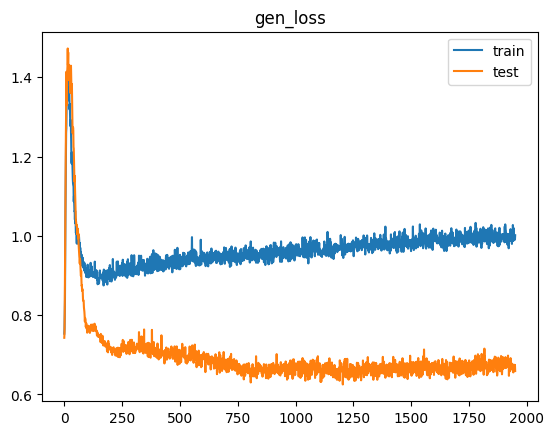

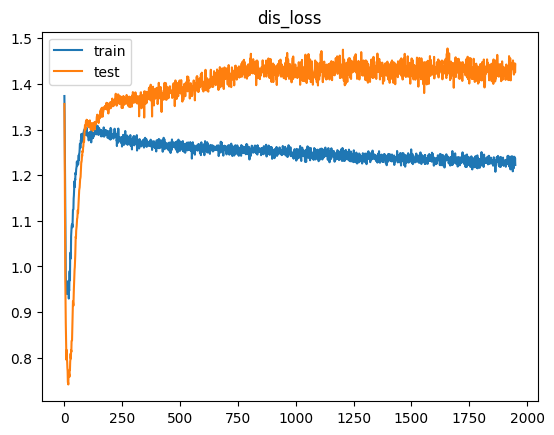

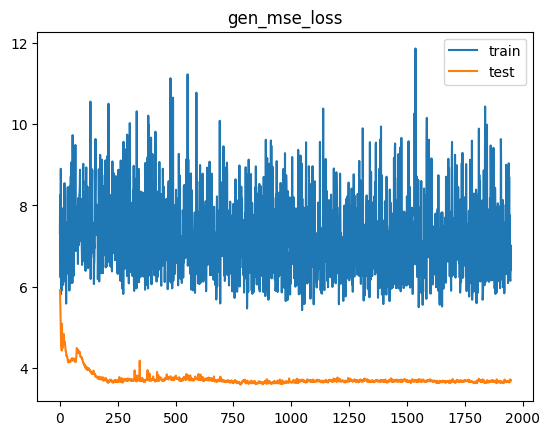

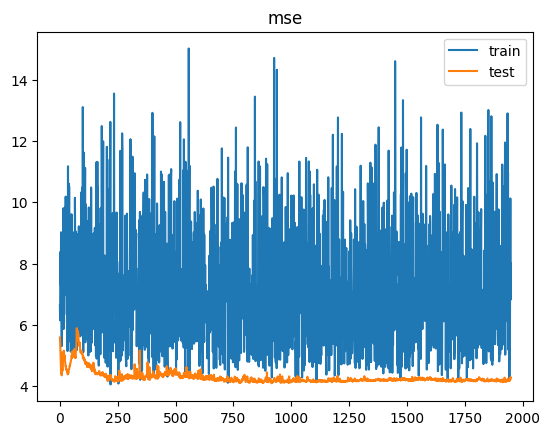

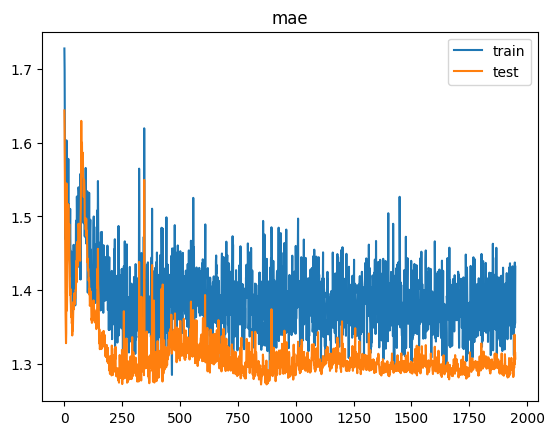

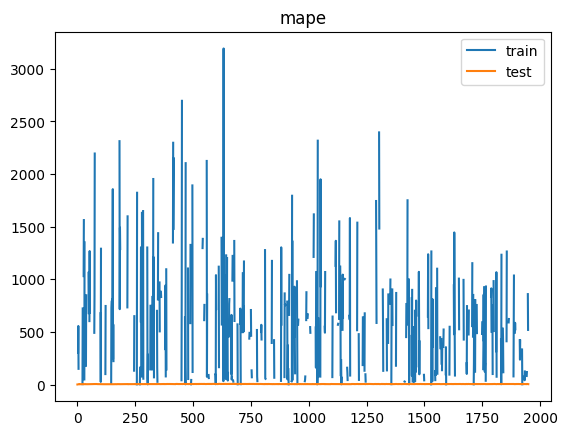

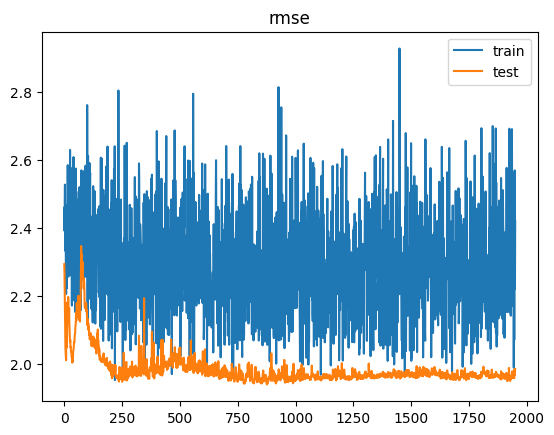

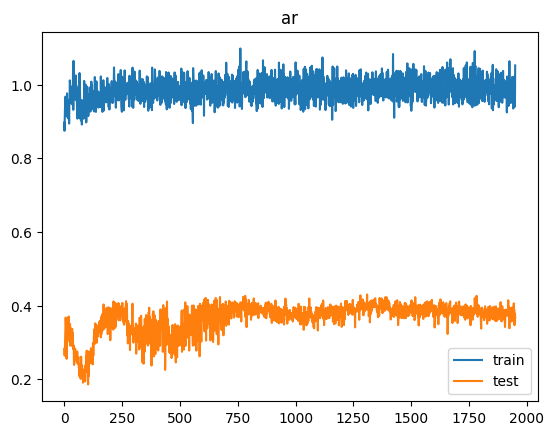

2/2 [==============================] - 0s 4ms/step


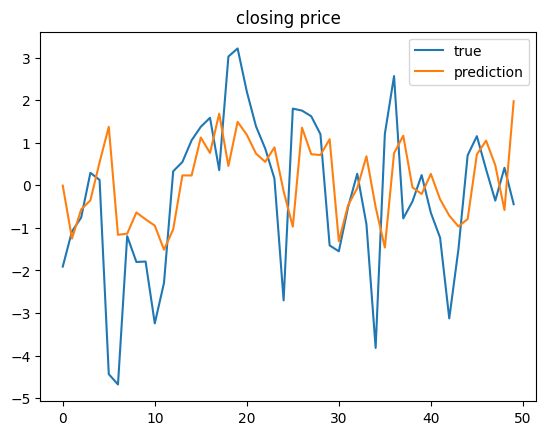

[MSE Baseline] train: 9.01748710886635  test: 4.18451216814071
Delta time with epochs = 1950: 0:32:56.850776


In [21]:
for epochs in [1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("rnn_ffnn_epochs_{0}.h5".format(epochs))